# Predict on new data using a trained CNN on XPS data on Google Colab

In this notebook, we will use a trained convolutional network to predict on unseen iron XPS spectra.

## Setup

### Mount google drive, change working directory

In [1]:
# Mount drive
from google.colab import drive
import os

drive.mount('/content/drive')

# Change working path
os.chdir('/content/drive/My Drive/app')

Mounted at /content/drive


### Install packages and import modules

In [2]:
# Install packages
!pip install python-docx
!pip install tensorflow==2.3.0 as tf # to be dropped when tf 2.4 works

# Import standard modules and magic commands
import datetime
import numpy as np
import pytz
import importlib
import matplotlib.pyplot as plt

# Magic commands
%matplotlib inline
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Disable tf warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import tensorflow as tf

     |████████████████████████████████| 5.5MB 4.0MB/s 
  Created wheel for python-docx: filename=python_docx-0.8.10-cp36-none-any.whl size=184491 sha256=66794686f6858d055144648c5b77233e0a214d79dff71274594ea272a17c2fa4
  Stored in directory: /root/.cache/pip/wheels/18/0b/a0/1dd62ff812c857c9e487f27d80d53d2b40531bec1acecfa47b
Successfully built python-docx
     |████████████████████████████████| 320.4MB 42kB/s 
     |████████████████████████████████| 460kB 41.3MB/s 
     |████████████████████████████████| 20.1MB 1.5MB/s 
  Created wheel for tf: filename=tf-1.0.0-cp36-none-any.whl size=1285 sha256=6cbb7f102b781160644d4c8e67b06e9df68662a531a2f6e715bd383e72bcc64b
  Stored in directory: /root/.cache/pip/wheels/7c/51/42/b034446bd6c8252825a1a0e7799b6ff633de376967db5ed5a6
Successfully built tf
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 

In [3]:
tf.__version__

'2.3.0'

## Predict on new data set

### Load custom modules

In [18]:
try:
    import importlib
    importlib.reload(classifier)
    importlib.reload(clfutils)
    print('\n Modules were reloaded.')
except:
    import xpsdeeplearning.network.classifier as classifier
    import xpsdeeplearning.network.utils as clfutils
    print('\n Modules were loaded.')


 Modules were loaded.


### Set up the parameters & folder structure

In [19]:
np.random.seed(502)
time = datetime.datetime.now().astimezone(pytz.timezone('Europe/Berlin')).strftime("%Y%m%d_%Hh%Mm")
data_name = 'Fe_multiple_4_classes_measured_predict_using_20201219_13h47m_after_574_epochs'

label_values = ['Fe metal', 'FeO', 'Fe3O4', 'Fe2O3']

clf = classifier.ClassifierMultiple(time = time,
                                    data_name = data_name,
                                    labels = label_values)

Model folder created at /saved_models/20210111_18h13m_Fe_multiple_4_classes_measured_predict_using_20201219_13h47m_after_574_epochs
Logs folder created at /logs/20210111_18h13m_Fe_multiple_4_classes_measured_predict_using_20201219_13h47m_after_574_epochs
Figures folder created at /figures/20210111_18h13m_Fe_multiple_4_classes_measured_predict_using_20201219_13h47m_after_574_epochs


### Load and inspect the data

Data was loaded!
Total no. of samples: 300
No. of training samples: 3
No. of validation samples: 0
No. of test samples: 297
Shape of each sample : 1121 features (X) + 4 labels (y)


/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  Means Delta Degrees of Freedom.  The divisor used in calculations
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in true_divide
  ret = ret / rcount


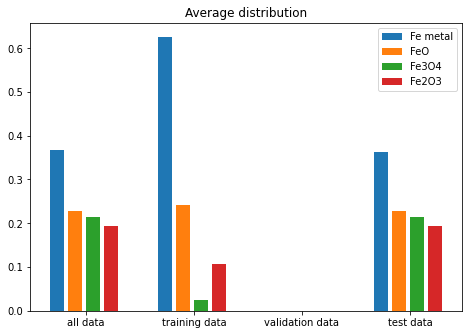

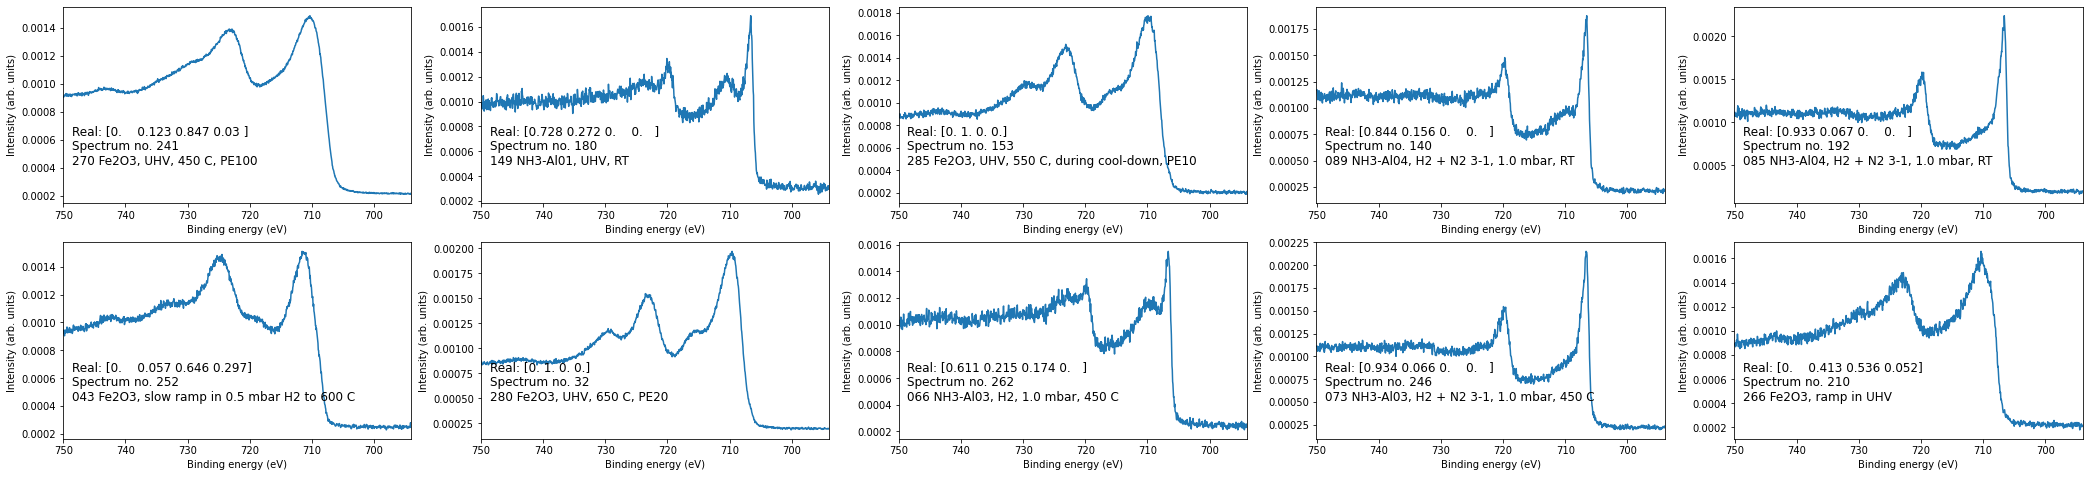

In [20]:
input_filepath = r'/content/drive/My Drive/app/datasets/20201207_iron_measured_tougaard_lineshapes.h5'

train_test_split = 0.99
train_val_split = 0
no_of_examples = 300

        
X_train, X_val, X_test, y_train, y_val, y_test,\
    names_train, names_val, names_test =\
        clf.load_data_preprocess(input_filepath = input_filepath,
                                 no_of_examples = no_of_examples,
                                 train_test_split = train_test_split,
                                 train_val_split = train_val_split)
        
# Check how the examples are distributed across the classes.
class_distribution = clf.check_class_distribution()
clf.plot_class_distribution()
clf.plot_random(no_of_spectra = 10, dataset = 'test')  

### Load the model

In [21]:
clf.load_model(model_path = '/content/drive/My Drive/app/saved_models/20201219_13h47m_Fe_multiple_4_classes_variable_linear_comb_new_noise_combined_data')

Loaded model from disk.


### Compile and summarize the model

Model: "Loaded_Model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1121, 1)]    0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 1121, 12)     72          input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 1121, 12)     132         input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 1121, 12)     192         input_1[0][0]                    
_______________________________________________________________________________________

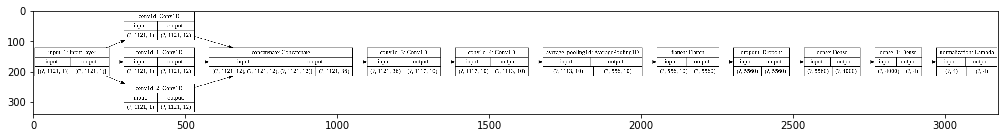

In [22]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError, MeanAbsoluteError

learning_rate = 1e-05
optimizer = Adam(learning_rate = learning_rate) 
mse = MeanSquaredError()
mae = MeanAbsoluteError()
# =============================================================================
# def custom_loss(y_true, y_pred):
#     """
#     Custom loss for linear combination of XPS spectra.
#     """
#     squared_difference = tf.square(tf.subtract(y_true,y_pred))
#     squared_output = tf.square(y_pred)
#     
#     return tf.reduce_sum(tf.multiply(squared_output,squared_difference))
# =============================================================================

# Compile model with build-in loss function
#clf.model.compile(loss = mse, optimizer = optimizer)
clf.model.compile(loss = mae, optimizer = optimizer)

# Plot summary and save model plot.
clf.summary()
clf.save_and_print_model_image()

### Evaluate on test data

In [23]:
clf.batch_size = 32
test_loss = clf.evaluate()
print('Test loss: ' + str(test_loss))

10/10 [==============================] - 1s 70ms/step - loss: 0.1111
Evaluation done! 

Test loss: 0.11109717190265656


###  Predict on train & test data

In [24]:
pred_train, pred_test = clf.predict()

10/10 [==============================] - 1s 69ms/step
Prediction done!


### Show some predictions on random test samples

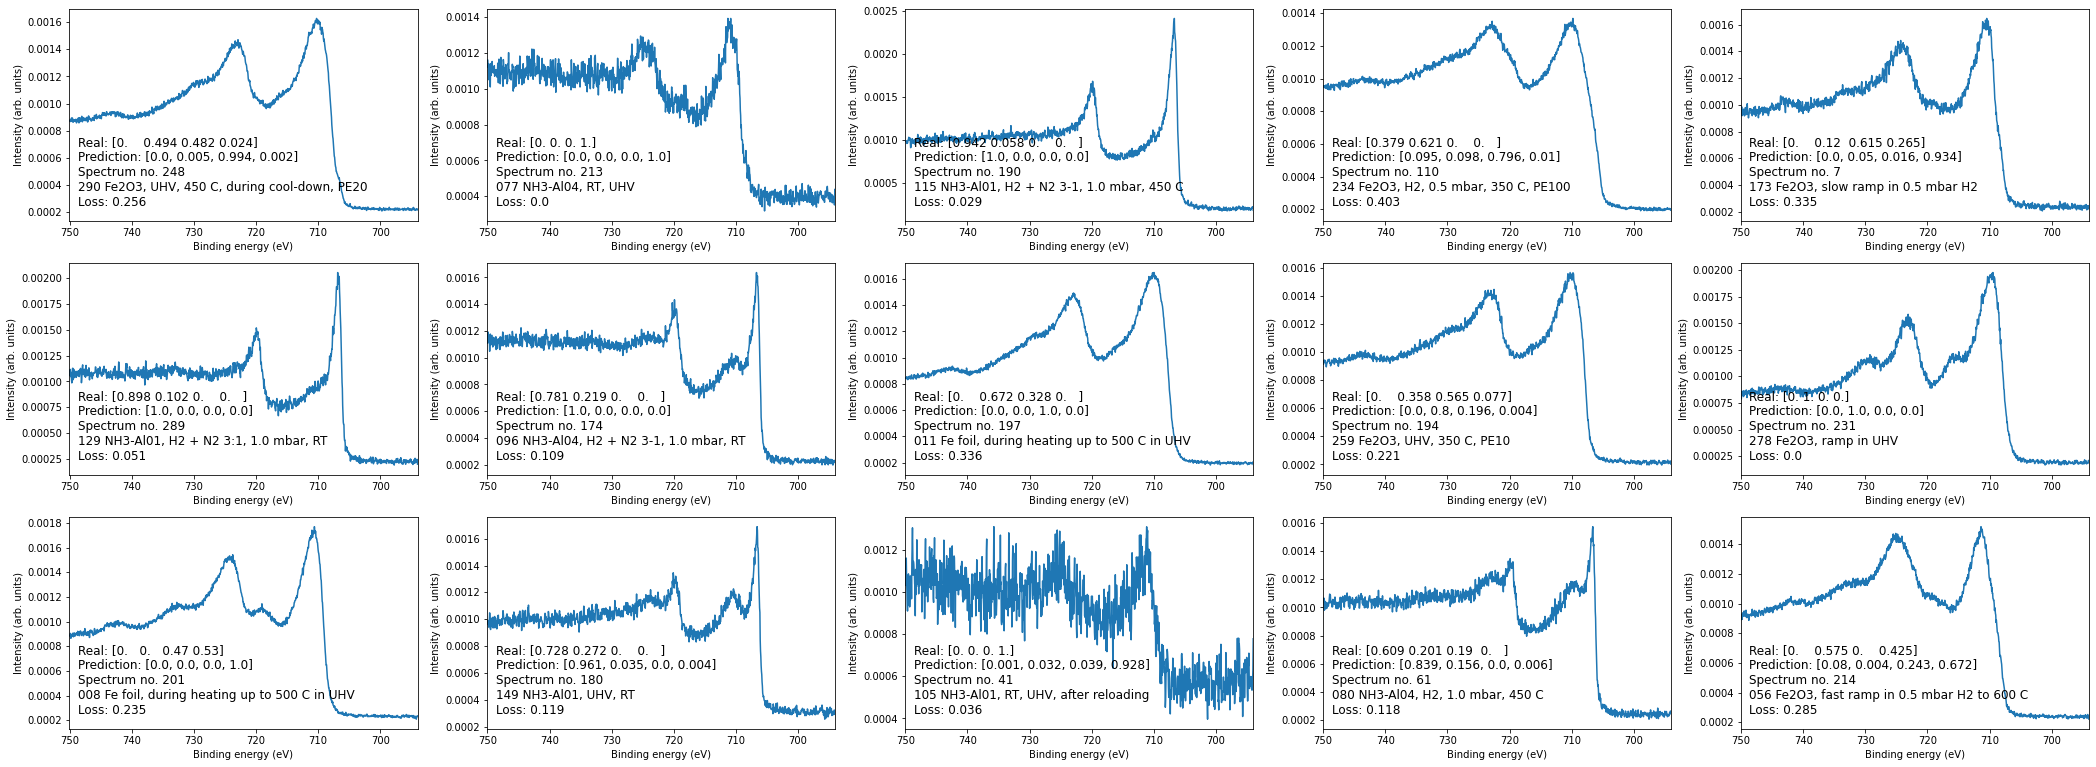

In [25]:
clf.plot_random(no_of_spectra = 15, dataset = 'test', with_prediction = True)  


### Show the worst predictions on the test samples

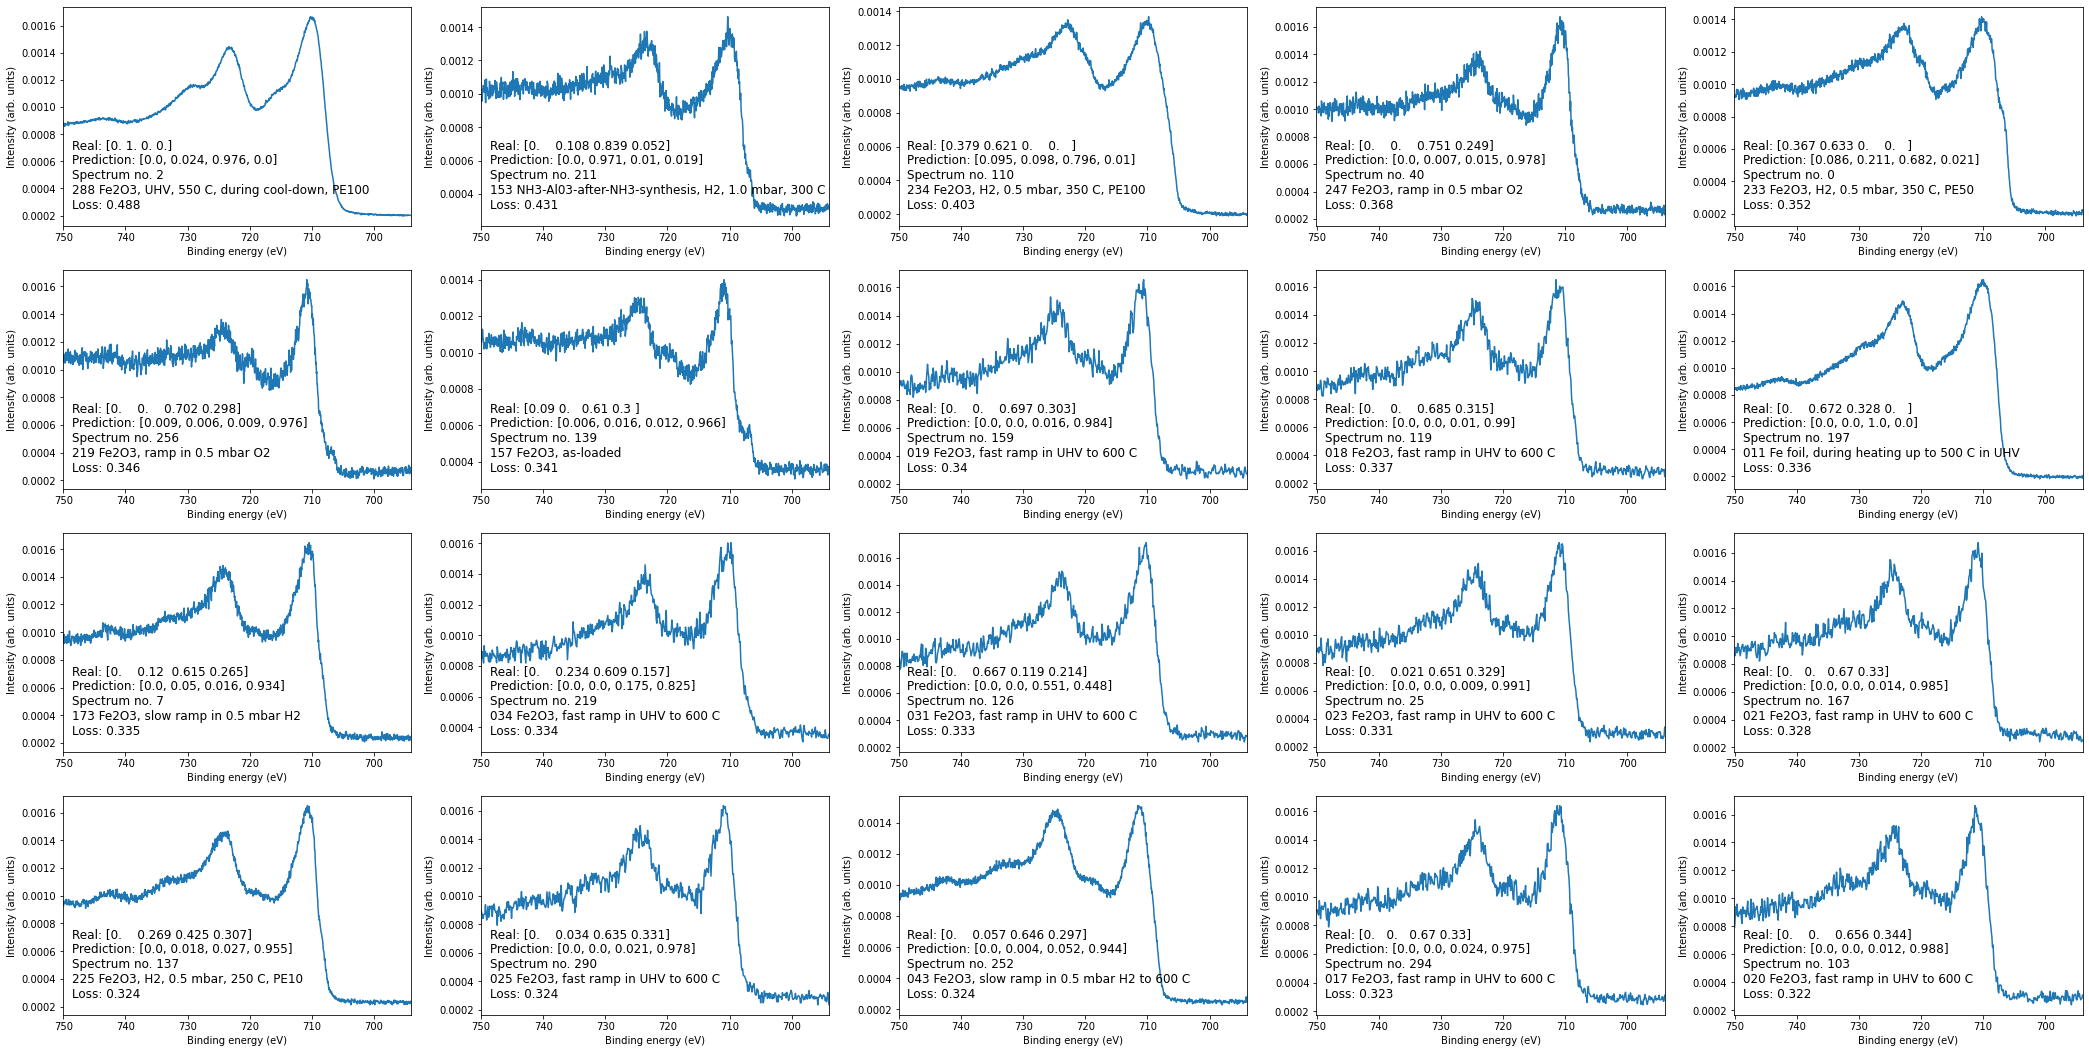

In [26]:
clf.show_worst_predictions(no_of_spectra = 20)

### Save data

In [27]:
clf.save_hyperparams()
clf.shelve_results(full = False)

Saved hyperparameters to file.
Saved results to file.


/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  Means Delta Degrees of Freedom.  The divisor used in calculations
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in true_divide
  ret = ret / rcount


## Check where and why the predictions fail

### Calculate loss for each example in the test set

In [28]:
mse = tf.keras.losses.MeanSquaredError()
mae = tf.keras.losses.MeanAbsoluteError()
mape = tf.keras.losses.MeanAbsolutePercentageError()

mse_losses = [mse(clf.y_test[i], clf.pred_test[i]).numpy() \
                  for i in range(clf.y_test.shape[0])]
mae_losses = [mae(clf.y_test[i], clf.pred_test[i]).numpy() \
                  for i in range(clf.y_test.shape[0])]
mape_losses = [mape(clf.y_test[i], clf.pred_test[i]).numpy() \
                  for i in range(clf.y_test.shape[0])]

In [29]:
def show_worst_of_one_kind(indices, spectra = [0,20]):
    if len(indices) > 0:
        no_of_spectra =  spectra[1] - spectra[0]
      
        no_of_cols = 5
        no_of_rows = int(no_of_spectra/no_of_cols)
        if (no_of_spectra % no_of_cols) != 0:
            no_of_rows += 1

        fig, axs = plt.subplots(nrows = no_of_rows, ncols = no_of_cols)
        plt.subplots_adjust(left = 0.125, bottom = 0.5,
                            right=4.8, top = no_of_rows,
                            wspace = 0.2, hspace = 0.2)                    
    
        for i in range(no_of_spectra):
            index = indices[spectra[0]+i]
            x = np.arange(694, 750.05, 0.05)
            y = clf.X_test[index]
            label = str(np.around(clf.y_test[index], decimals = 3))
            full_text = 'Real: ' +  label + '\n'
             
            tmp_array = np.around(clf.pred_test[index], decimals = 3) 
            full_text += 'Prediction: ' + str(list(tmp_array)) + '\n'
            try:
                full_text += clf._write_aug_text(dataset = 'test',
                                                 index = index)
            except AttributeError:
                pass
            try:
                full_text += clf._write_measured_text(dataset = 'test',
                                                      index = index)
            except AttributeError:
                 pass
            loss_text = ('MSE: ' + str(np.around(mse_losses[index], decimals = 3)) + ', ' +\
                         'MAE: ' + str(np.around(mae_losses[index], decimals = 3)))
         
            row, col = int(i/no_of_cols), i % no_of_cols
            try:
                axs[row, col].plot(np.flip(x),y)
                axs[row, col].invert_xaxis()
                axs[row, col].set_xlim(750.05,694)
                axs[row, col].set_xlabel('Binding energy (eV)')
                axs[row, col].set_ylabel('Intensity (arb. units)')                          
                axs[row, col].text(0.025, 0.4, full_text + loss_text,
                                   horizontalalignment='left',
                                   verticalalignment='top',
                                   transform = axs[row, col].transAxes,
                                   fontsize = 11.5) 
            except IndexError:
                axs[row].plot(np.flip(x),y)
                axs[row].invert_xaxis()
                axs[row].set_xlim(750.05,694)
                axs[row].set_xlabel('Binding energy (eV)')
                axs[row].set_ylabel('Intensity (arb. units)')                          
                axs[row].text(0.025, 0.4, full_text + loss_text,
                              horizontalalignment='left',
                              verticalalignment='top',
                              transform = axs[row].transAxes,
                              fontsize = 11.5) 
    else:
      pass

### Show worst predictions for single iron spectra

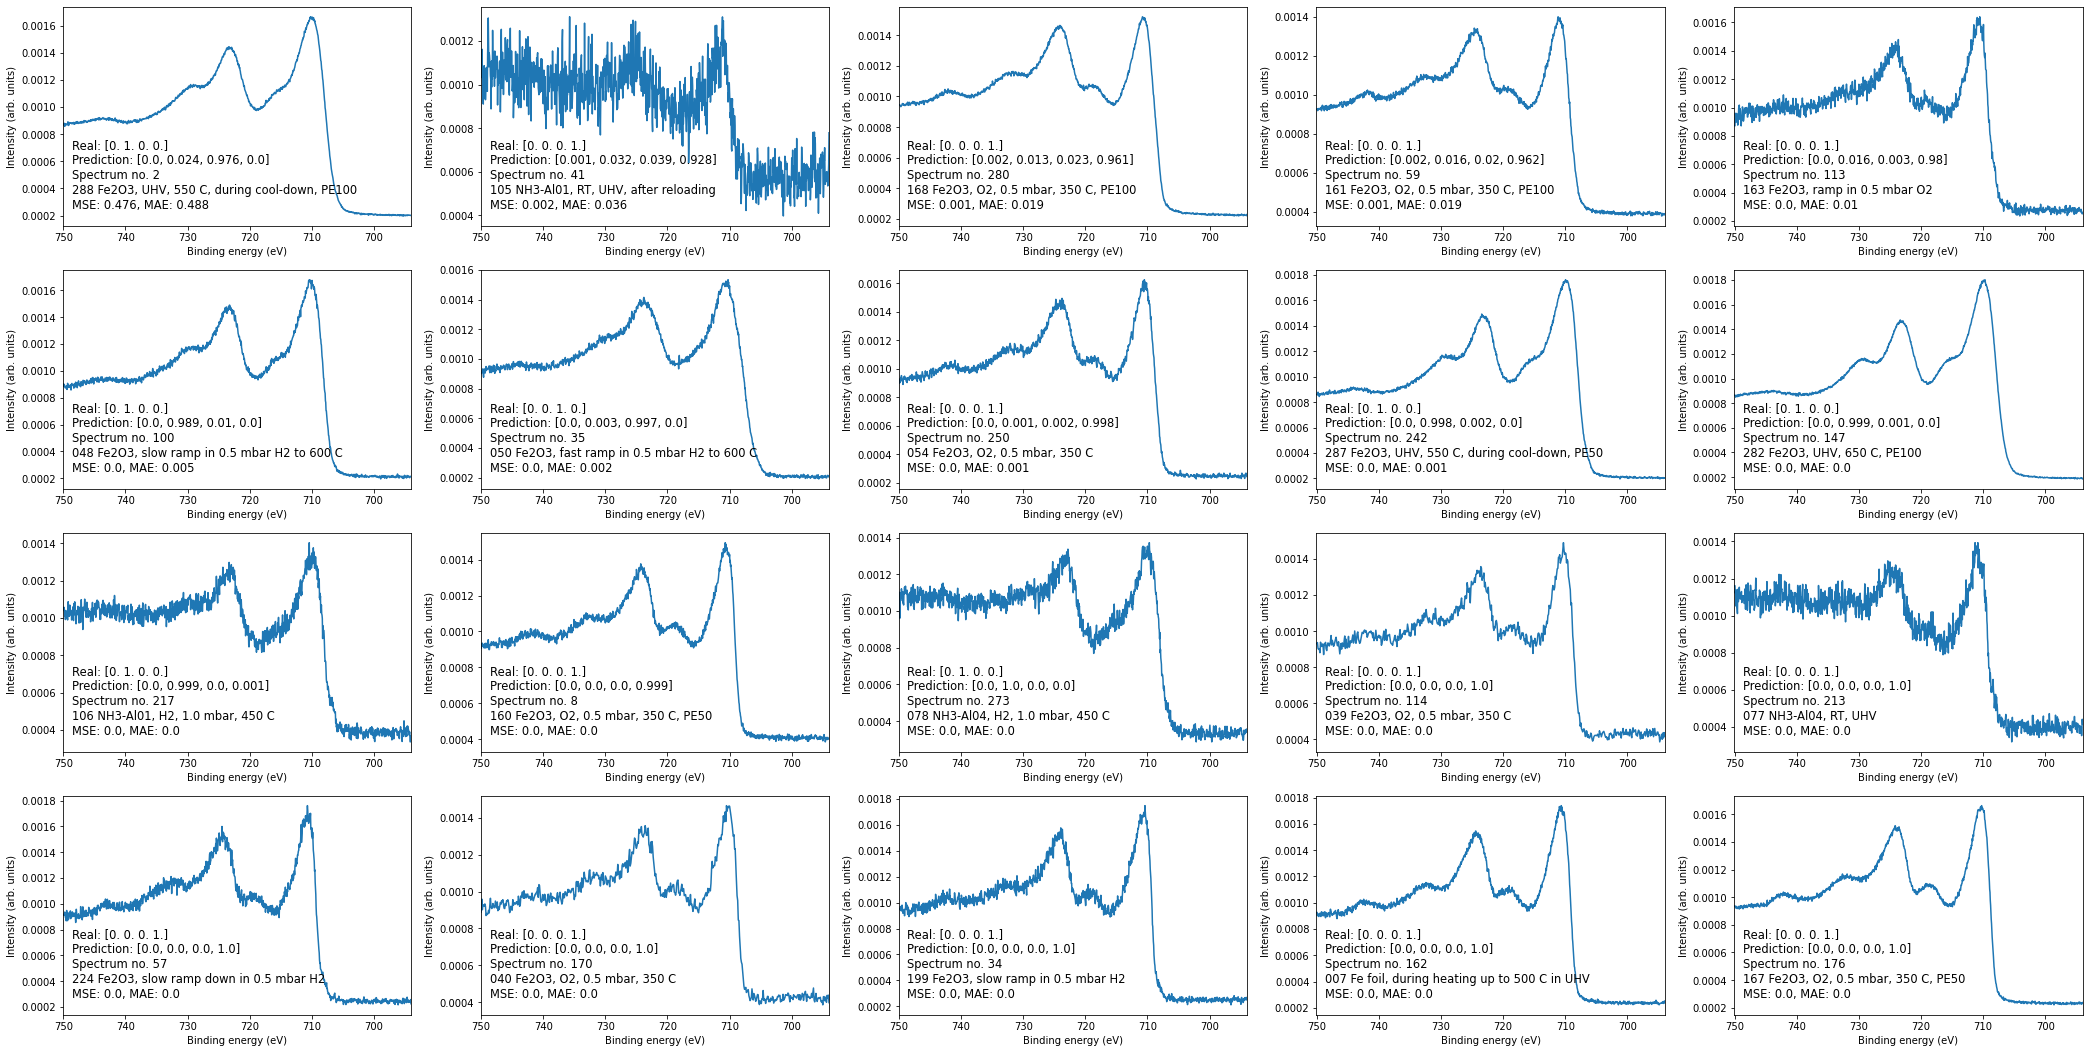

In [30]:
worst_indices_single = [j[1] for j in sorted([(x,i) for (i,x) in \
                                        enumerate(mae_losses) if len(np.where(clf.y_test[i] == 0.)[0]) == 3],
                                        reverse=True)] 
show_worst_of_one_kind(worst_indices_single, spectra = [0,20])

### Show worst predictions for different loss thresholds (single iron spectra)


In [ ]:
threshold = 0.2
worst_indices_single_01 = [j[1] for j in sorted([(x,i) for (i,x) in \
                           enumerate(mae_losses) if (len(np.where(clf.y_test[i] == 0.)[0]) == 3 and x >= threshold)],
                           reverse=True)]
  
show_worst_of_one_kind(worst_indices_single_01,
                       spectra = [len(worst_indices_single_01)-10,
                                  len(worst_indices_single_01)])

print('{0} of {1} test samples with single iron species ({2}%) have a mean absolute error of of at least {3}.'.format(
    str(len(worst_indices_single_01)),
    str(len(worst_indices_single)),
    str(100*(np.around(len(worst_indices_single_01)/len(worst_indices_single), decimals = 3))),
    str(threshold)))

In [ ]:
threshold = 0.1
worst_indices_single_02 = [j[1] for j in sorted([(x,i) for (i,x) in \
                        enumerate(mae_losses) if (len(np.where(clf.y_test[i] == 0.)[0]) == 3 and x >= threshold)],
                        reverse=True)]

show_worst_of_one_kind(worst_indices_single_02,
                       spectra = [len(worst_indices_single_02)-10,
                                  len(worst_indices_single_02)])

print('{0} of {1} test samples with single iron species ({2}%) have a mean absolute error of of at least {3}.'.format(
    str(len(worst_indices_single_02)),
    str(len(worst_indices_single)),
    str(100*(np.around(len(worst_indices_single_02)/len(worst_indices_single), decimals = 3))),
    str(threshold)))

In [ ]:
threshold = 0.05
worst_indices_single_03 = [j[1] for j in sorted([(x,i) for (i,x) in \
                        enumerate(mae_losses) if (len(np.where(clf.y_test[i] == 0.)[0]) == 3 and x >= threshold)],
                        reverse=True)]

show_worst_of_one_kind(worst_indices_single_03,
                       spectra = [len(worst_indices_single_03)-10,
                                  len(worst_indices_single_03)])

print('{0} of {1} test samples with single iron species ({2}%) have a mean absolute error of of at least {3}.'.format(
    str(len(worst_indices_single_03)),
    str(len(worst_indices_single)),
    str(100*(np.around(len(worst_indices_single_03)/len(worst_indices_single), decimals = 3))),
    str(threshold)))

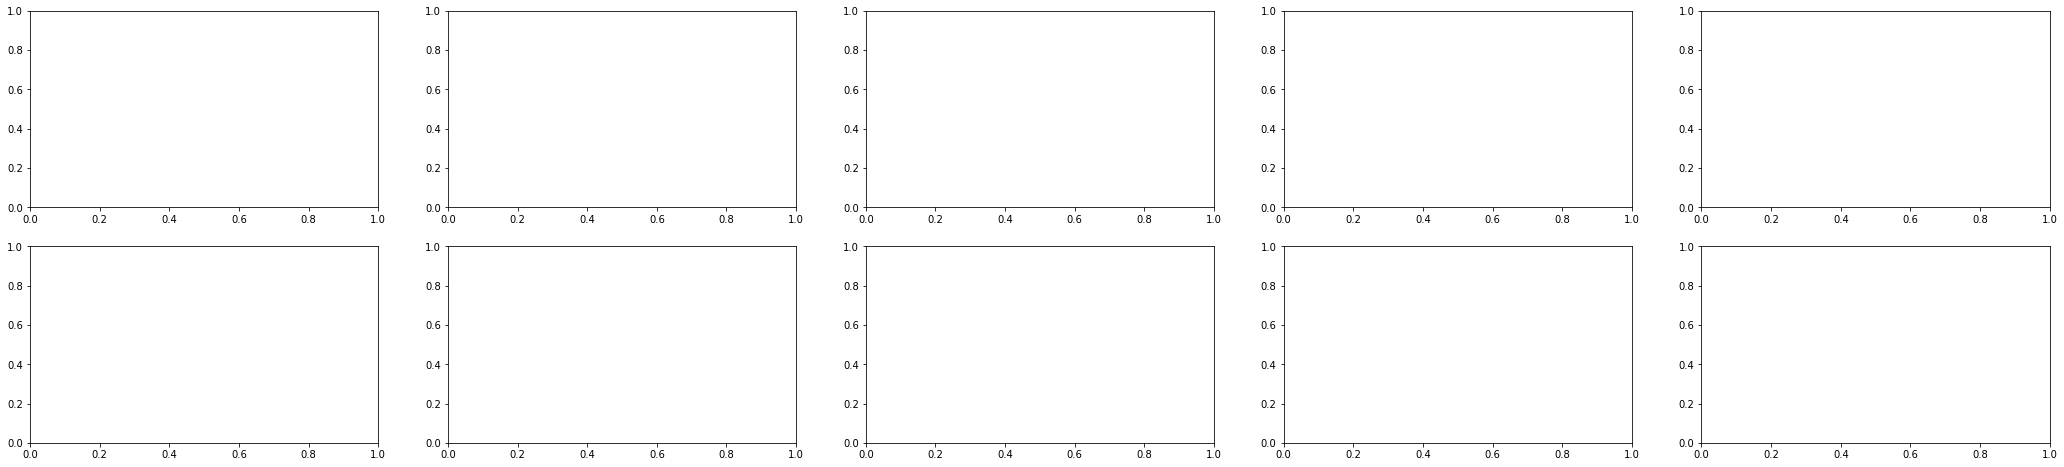

In [34]:
threshold = 0.02
worst_indices_single_04 = [j[1] for j in sorted([(x,i) for (i,x) in \
                        enumerate(mae_losses) if (len(np.where(clf.y_test[i] == 0.)[0]) == 3 and x >= threshold)],
                        reverse=True)]

show_worst_of_one_kind(worst_indices_single_04,
                       spectra = [len(worst_indices_single_04)-10,
                                  len(worst_indices_single_04)])

print('{0} of {1} test samples with single iron species ({2}%) have a mean absolute error of of at least {3}.'.format(
    str(len(worst_indices_single_04)),
    str(len(worst_indices_single)),
    str(100*(np.around(len(worst_indices_single_04)/len(worst_indices_single), decimals = 3))),
    str(threshold)))

In [ ]:
threshold = 0.01
worst_indices_single_05 = [j[1] for j in sorted([(x,i) for (i,x) in \
                        enumerate(mae_losses) if (len(np.where(clf.y_test[i] == 0.)[0]) == 3 and x >= threshold)],
                        reverse=True)]

show_worst_of_one_kind(worst_indices_single_05,
                       spectra = [len(worst_indices_single_05)-10,
                                  len(worst_indices_single_05)])

print('{0} of {1} test samples with single iron species ({2}%) have a mean absolute error of of at least {3}.'.format(
    str(len(worst_indices_single_05)),
    str(len(worst_indices_single)),
    str(100*(np.around(len(worst_indices_single_05)/len(worst_indices_single), decimals = 3))),
    str(threshold)))

### Show worst predictions for linearly combined iron spectra

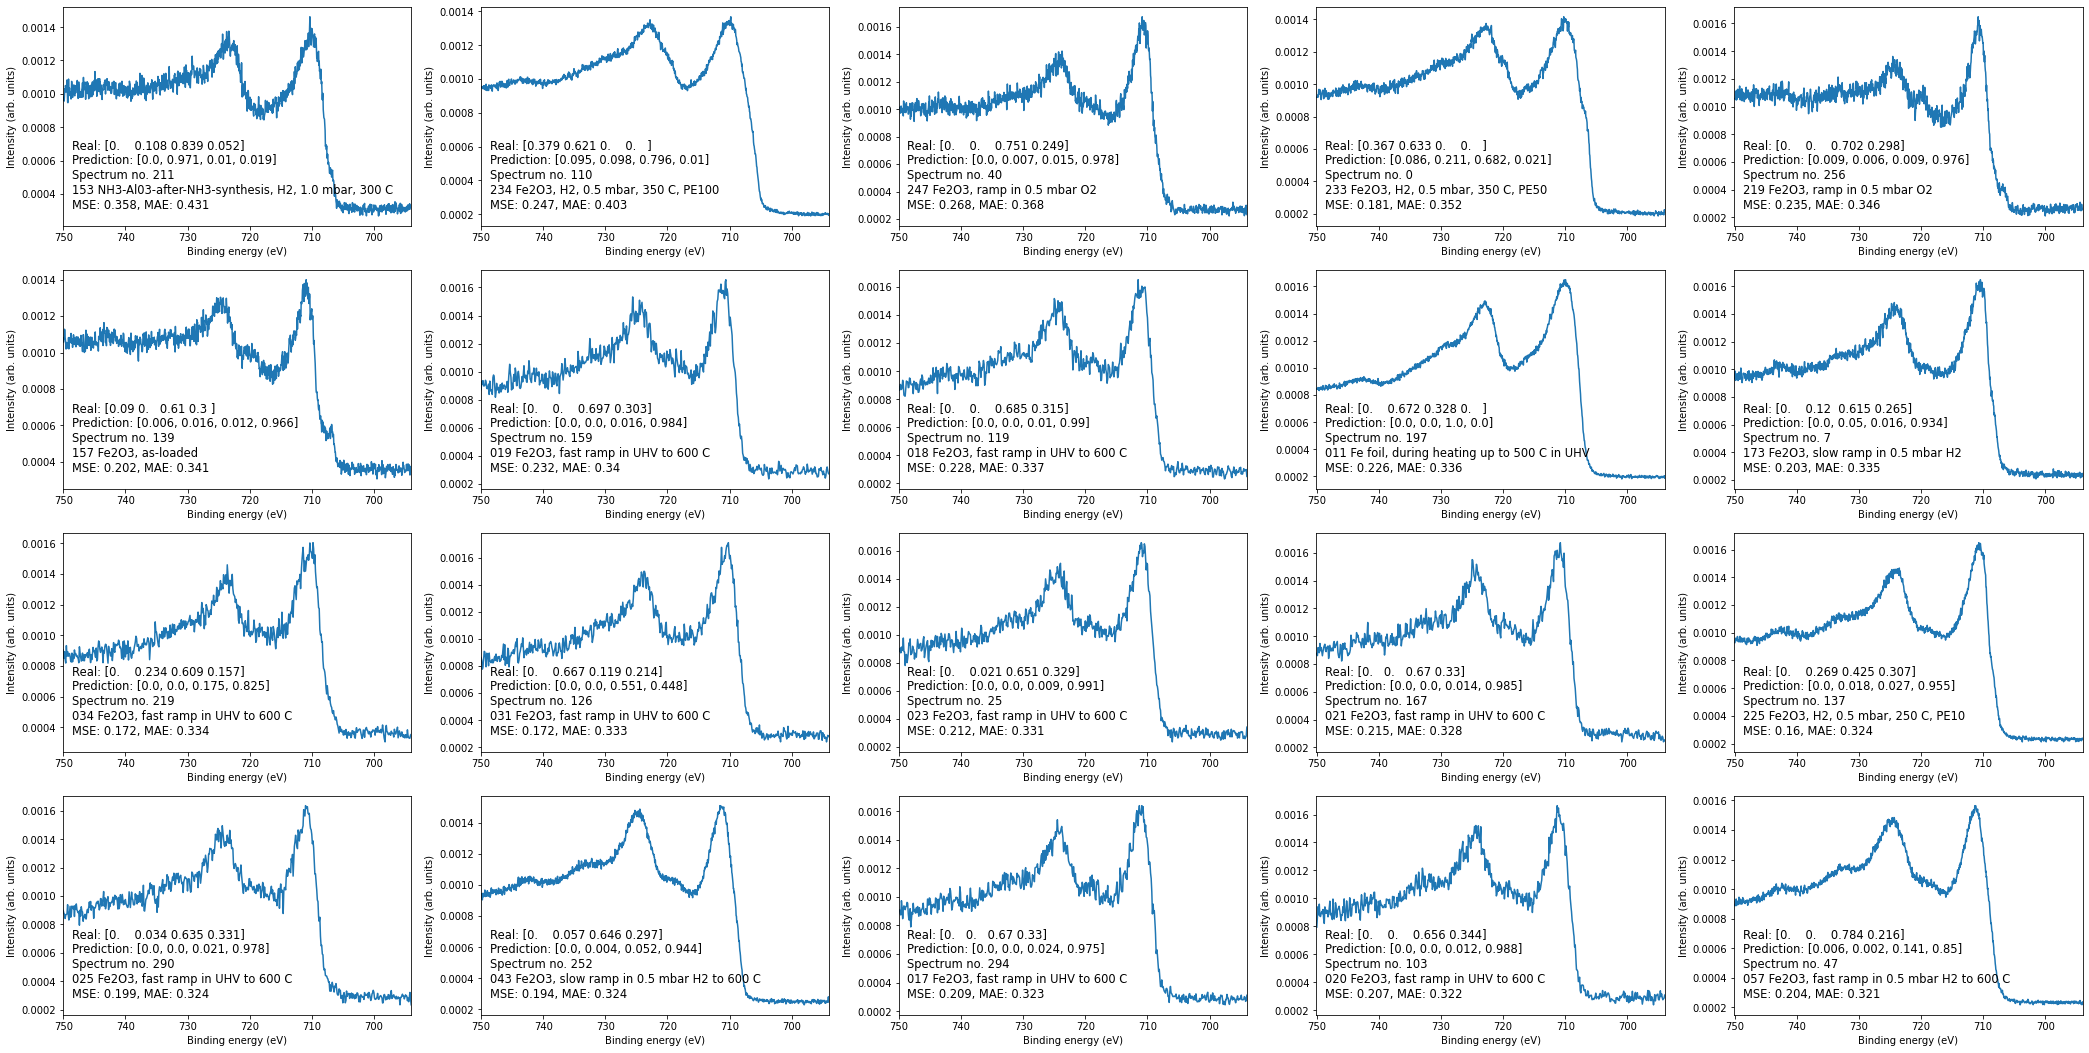

In [35]:
worst_indices_multiple = [j[1] for j in sorted([(x,i) for (i,x) in \
                          enumerate(mae_losses) if len(np.where(clf.y_test[i] == 0.)[0]) != 3],
                          reverse=True)] 
show_worst_of_one_kind(worst_indices_multiple, spectra = [0,20])

### Show worst predictions for different loss thresholds (linearly combined iron spectra)

26 of 212 test samples with multiple iron species (12.3%) have a mean absolute error of of at least 0.3.


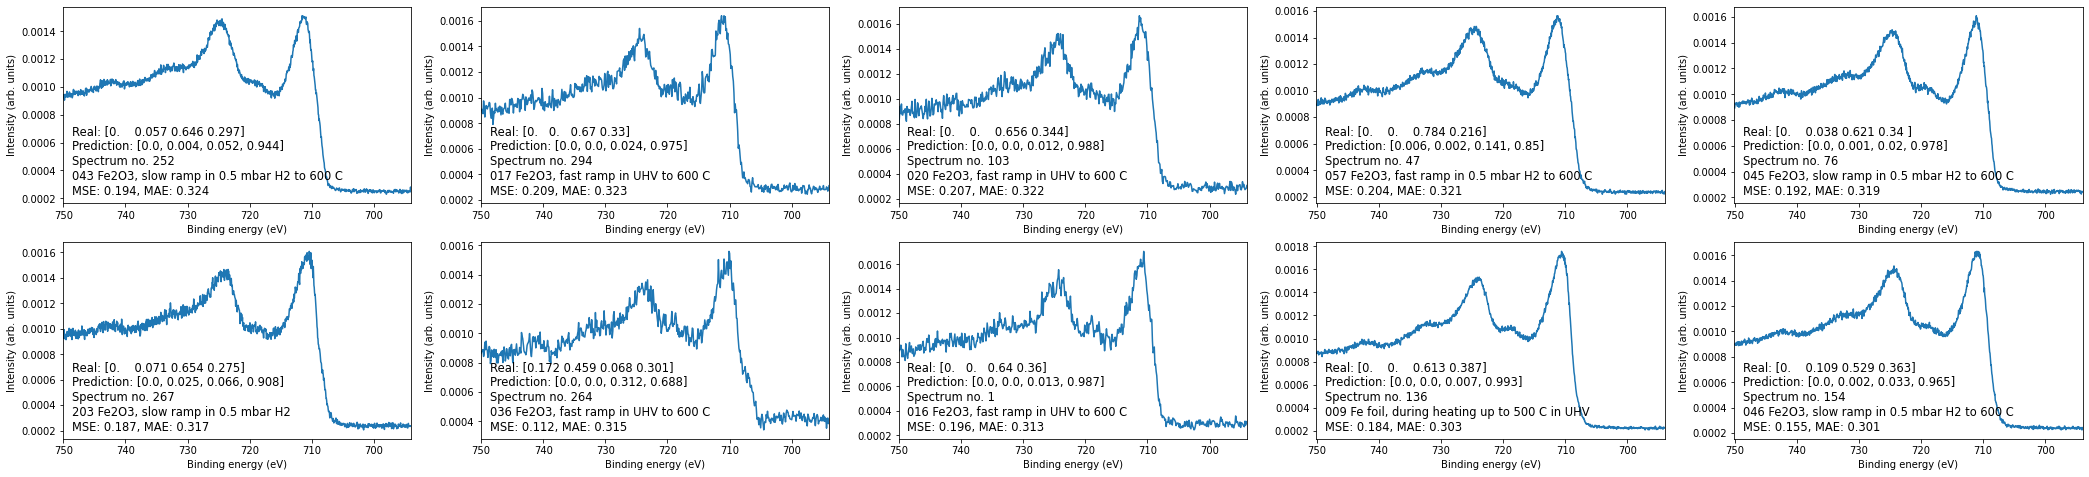

In [36]:
threshold = 0.3
worst_indices_multiple_01 = [j[1] for j in sorted([(x,i) for (i,x) in \
                             enumerate(mae_losses) if (len(np.where(clf.y_test[i] == 0.)[0]) != 3 and x >= threshold)],
                             reverse=True)]  
                                             
show_worst_of_one_kind(worst_indices_multiple_01,
                       spectra = [len(worst_indices_multiple_01)-10,
                                 len(worst_indices_multiple_01)])

print('{0} of {1} test samples with multiple iron species ({2}%) have a mean absolute error of of at least {3}.'.format(
    str(len(worst_indices_multiple_01)),
    str(len(worst_indices_multiple)),
    str(100*(np.around(len(worst_indices_multiple_01)/len(worst_indices_multiple), decimals = 3))),
    str(threshold)))

74 of 212 test samples with multiple iron species (34.9%) have a mean absolute error of of at least 0.2.


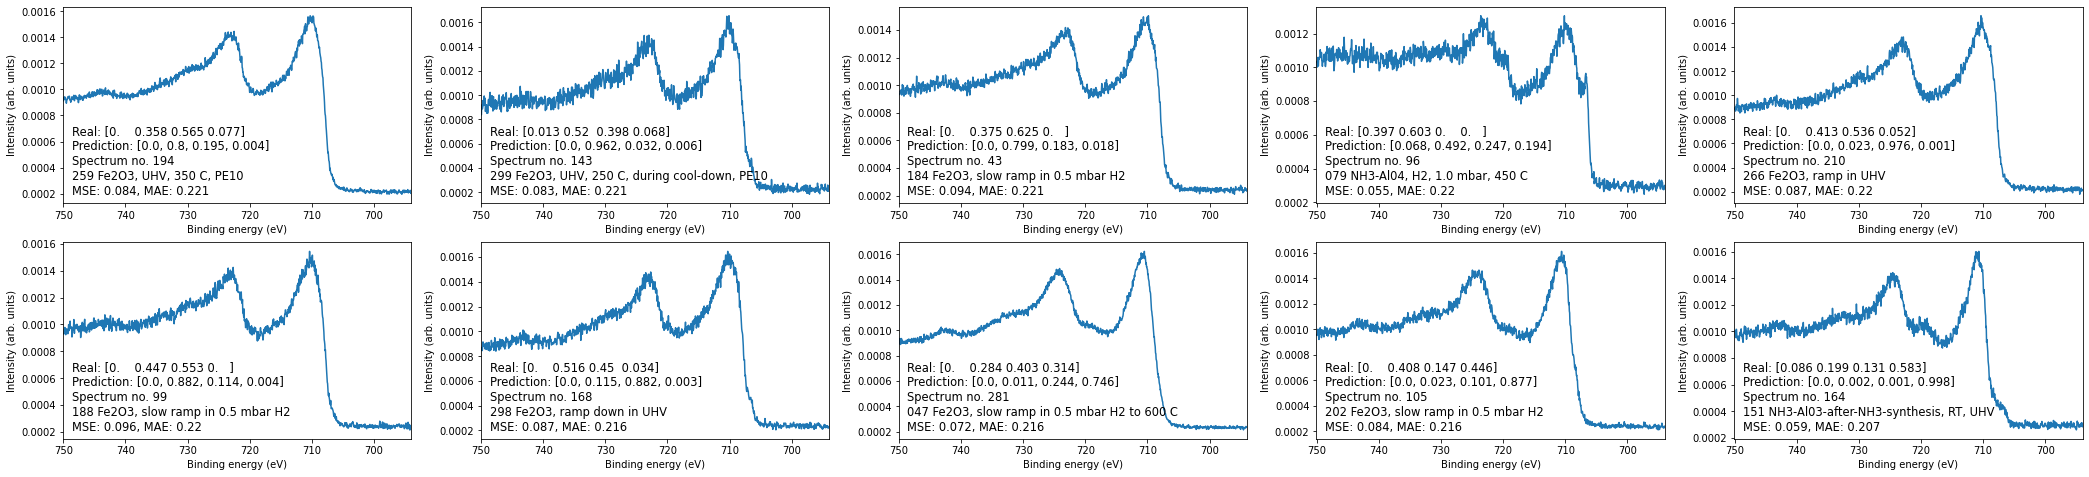

In [37]:
threshold = 0.2
worst_indices_multiple_02 = [j[1] for j in sorted([(x,i) for (i,x) in \
                            enumerate(mae_losses) if (len(np.where(clf.y_test[i] == 0.)[0]) != 3 and x >= threshold)],
                            reverse=True)]     

show_worst_of_one_kind(worst_indices_multiple_02,
                           spectra = [len(worst_indices_multiple_02)-10,
                                      len(worst_indices_multiple_02)])


print('{0} of {1} test samples with multiple iron species ({2}%) have a mean absolute error of of at least {3}.'.format(
    str(len(worst_indices_multiple_02)),
    str(len(worst_indices_multiple)),
    str(100*(np.around(len(worst_indices_multiple_02)/len(worst_indices_multiple), decimals = 3))),
    str(threshold)))

124 of 212 test samples with multiple iron species (58.5%) have a mean absolute error of of at least 0.1.


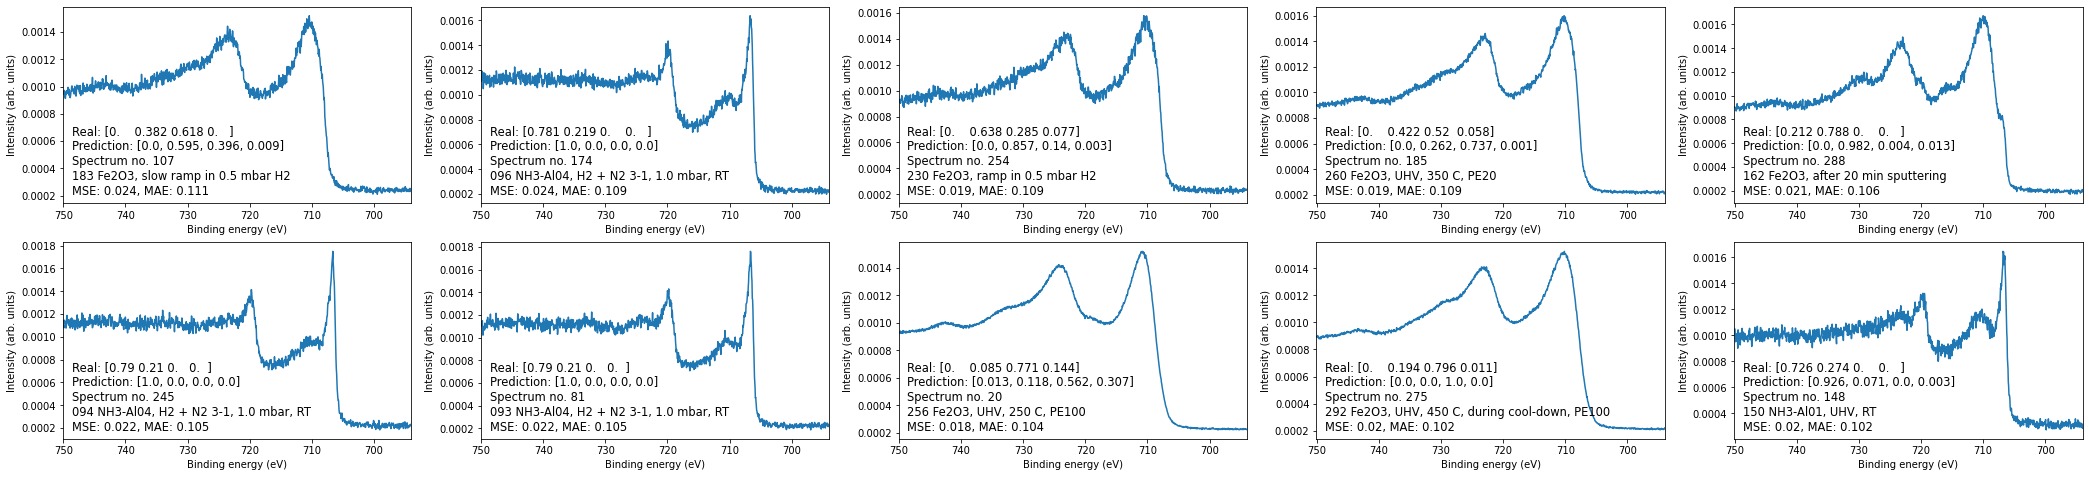

In [38]:
threshold = 0.1
worst_indices_multiple_03 = [j[1] for j in sorted([(x,i) for (i,x) in \
                             enumerate(mae_losses) if (len(np.where(clf.y_test[i] == 0.)[0]) != 3 and x >= threshold)],
                             reverse=True)]                  

if (len(worst_indices_multiple_03)) > 10:
    show_worst_of_one_kind(worst_indices_multiple_03,
                           spectra = [len(worst_indices_multiple_03)-10,
                                      len(worst_indices_multiple_03)])
else:
    show_worst_of_one_kind(worst_indices_multiple_03,
                           spectra = [0,
                                      len(worst_indices_multiple_03)])

print('{0} of {1} test samples with multiple iron species ({2}%) have a mean absolute error of of at least {3}.'.format(
    str(len(worst_indices_multiple_03)),
    str(len(worst_indices_multiple)),
    str(100*(np.around(len(worst_indices_multiple_03)/len(worst_indices_multiple), decimals = 3))),
    str(threshold)))

166 of 212 test samples with multiple iron species (78.3%) have a mean absolute error of of at least 0.05.


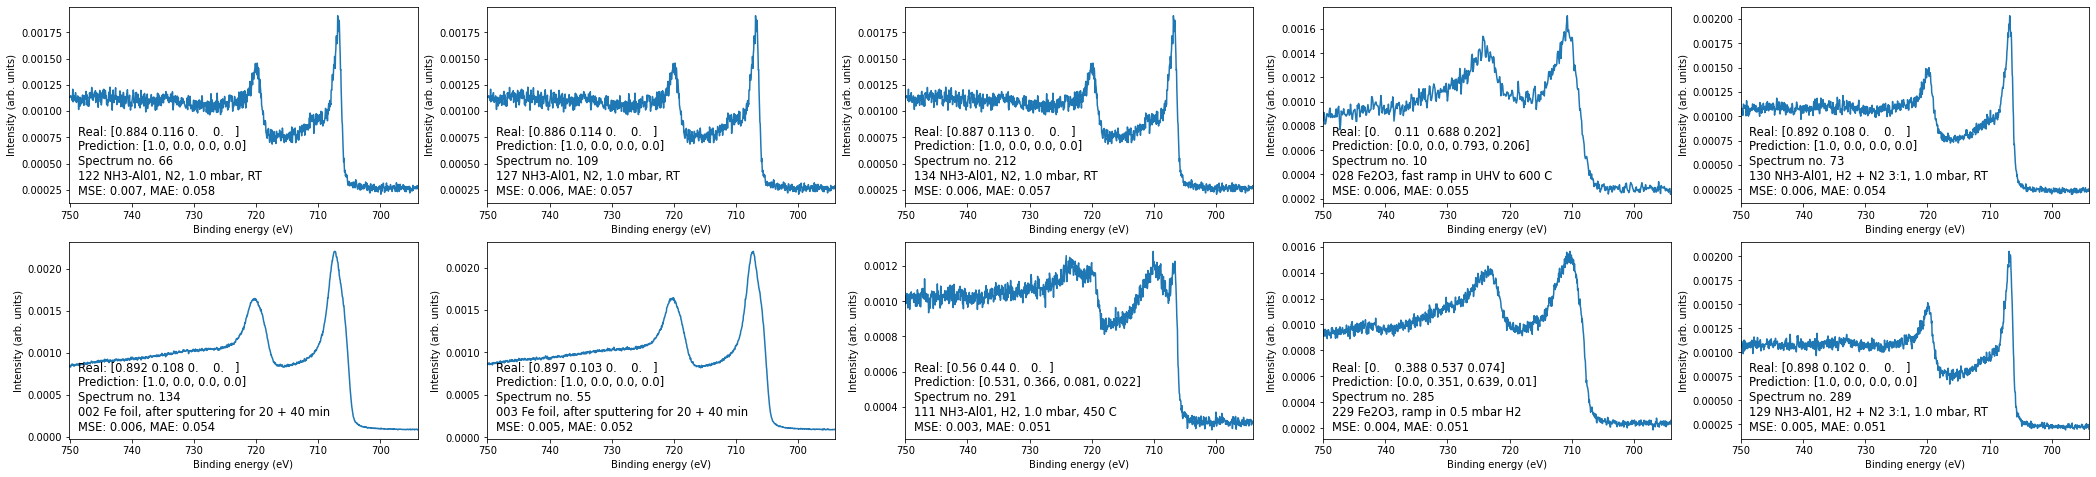

In [39]:
threshold = 0.05
worst_indices_multiple_04 = [j[1] for j in sorted([(x,i) for (i,x) in \
                             enumerate(mae_losses) if (len(np.where(clf.y_test[i] == 0.)[0]) != 3 and x >= threshold)],
                             reverse=True)]                  

if (len(worst_indices_multiple_04)) > 10:
    show_worst_of_one_kind(worst_indices_multiple_04,
                           spectra = [len(worst_indices_multiple_04)-10,
                                      len(worst_indices_multiple_04)])
else:
    show_worst_of_one_kind(worst_indices_multiple_04,
                           spectra = [0,
                                      len(worst_indices_multiple_04)])

print('{0} of {1} test samples with multiple iron species ({2}%) have a mean absolute error of of at least {3}.'.format(
    str(len(worst_indices_multiple_04)),
    str(len(worst_indices_multiple)),
    str(100*(np.around(len(worst_indices_multiple_04)/len(worst_indices_multiple), decimals = 3))),
    str(threshold)))

198 of 212 test samples with multiple iron species (93.4%) have a mean absolute error of of at least 0.025.


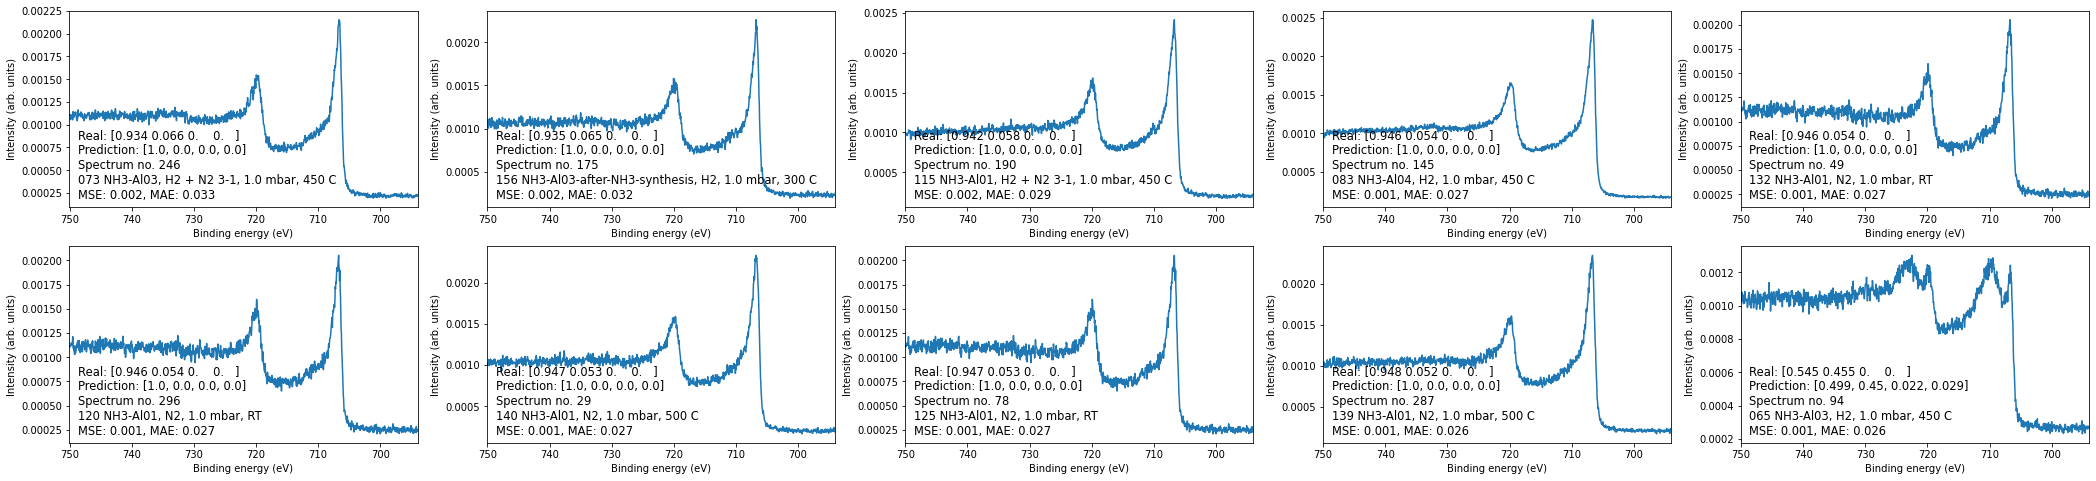

In [40]:
threshold = 0.025
worst_indices_multiple_05 = [j[1] for j in sorted([(x,i) for (i,x) in \
                             enumerate(mae_losses) if (len(np.where(clf.y_test[i] == 0.)[0]) != 3 and x >= threshold)],
                             reverse=True)]                  

if (len(worst_indices_multiple_05)) > 10:
    show_worst_of_one_kind(worst_indices_multiple_05,
                           spectra = [len(worst_indices_multiple_05)-10,
                                      len(worst_indices_multiple_05)])
else:
    show_worst_of_one_kind(worst_indices_multiple_05,
                           spectra = [0,
                                      len(worst_indices_multiple_05)])

print('{0} of {1} test samples with multiple iron species ({2}%) have a mean absolute error of of at least {3}.'.format(
    str(len(worst_indices_multiple_05)),
    str(len(worst_indices_multiple)),
    str(100*(np.around(len(worst_indices_multiple_05)/len(worst_indices_multiple), decimals = 3))),
    str(threshold)))

208 of 212 test samples with multiple iron species (98.1%) have a mean absolute error of of at least 0.01.


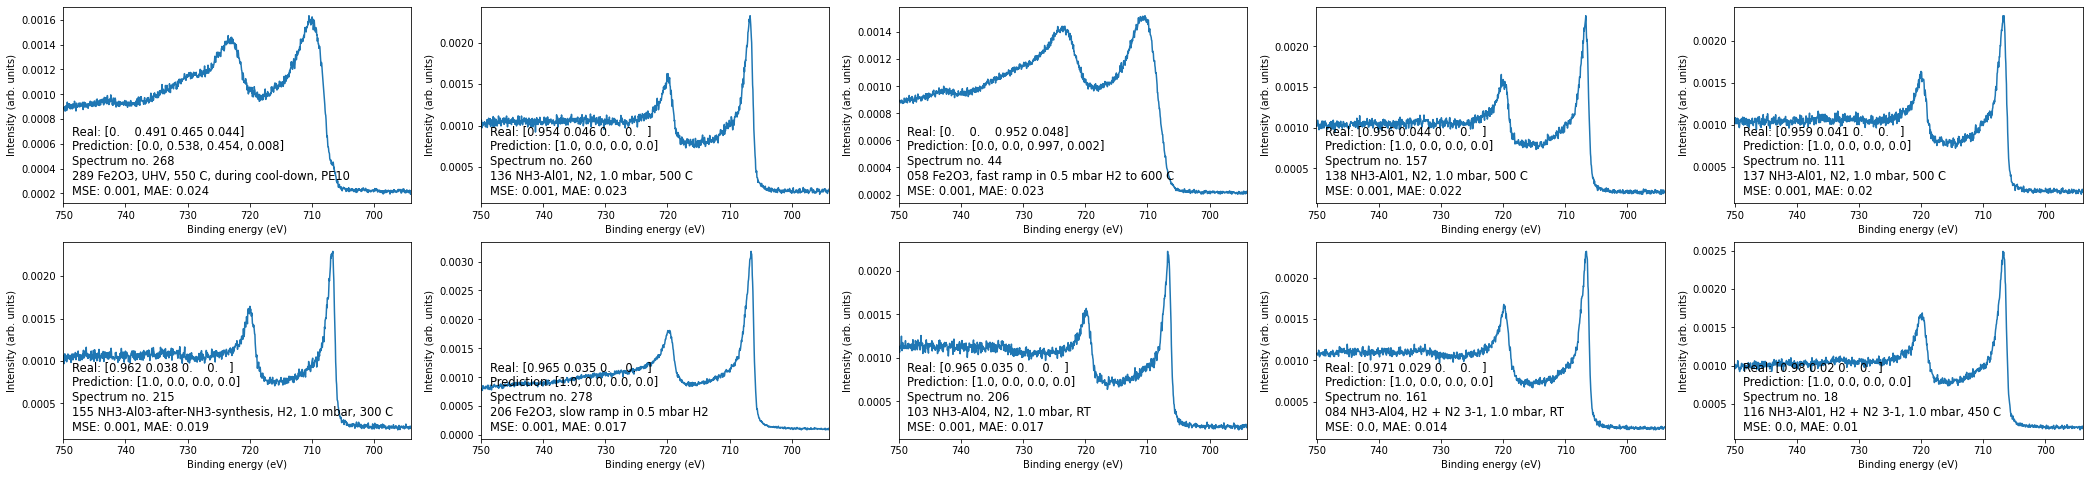

In [41]:
threshold = 0.01
worst_indices_multiple_06 = [j[1] for j in sorted([(x,i) for (i,x) in \
                             enumerate(mae_losses) if (len(np.where(clf.y_test[i] == 0.)[0]) != 3 and x >= threshold)],
                             reverse=True)]                  

if (len(worst_indices_multiple_06)) > 10:
    show_worst_of_one_kind(worst_indices_multiple_06,
                           spectra = [len(worst_indices_multiple_06)-10,
                                      len(worst_indices_multiple_06)])
else:
    show_worst_of_one_kind(worst_indices_multiple_06,
                           spectra = [0,
                                      len(worst_indices_multiple_06)])

print('{0} of {1} test samples with multiple iron species ({2}%) have a mean absolute error of of at least {3}.'.format(
    str(len(worst_indices_multiple_06)),
    str(len(worst_indices_multiple)),
    str(100*(np.around(len(worst_indices_multiple_06)/len(worst_indices_multiple), decimals = 3))),
    str(threshold)))

212 of 212 test samples with multiple iron species (100.0%) have a mean absolute error of of at least 0.005.


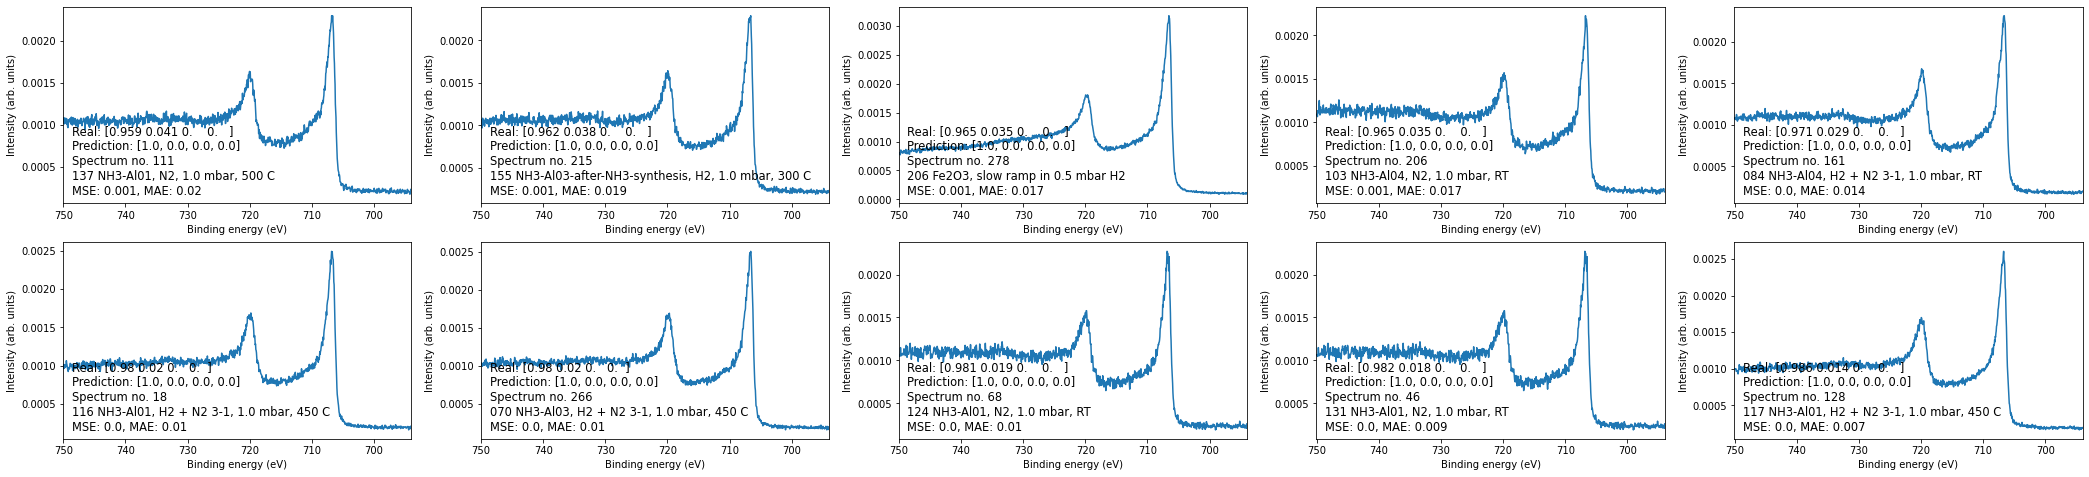

In [42]:
threshold = 0.005
worst_indices_multiple_07 = [j[1] for j in sorted([(x,i) for (i,x) in \
                             enumerate(mae_losses) if (len(np.where(clf.y_test[i] == 0.)[0]) != 3 and x >= threshold)],
                             reverse=True)]                  

if (len(worst_indices_multiple_07)) > 10:
    show_worst_of_one_kind(worst_indices_multiple_07,
                           spectra = [len(worst_indices_multiple_07)-10,
                                      len(worst_indices_multiple_07)])
else:
    show_worst_of_one_kind(worst_indices_multiple_07,
                           spectra = [0,
                                      len(worst_indices_multiple_07)])

print('{0} of {1} test samples with multiple iron species ({2}%) have a mean absolute error of of at least {3}.'.format(
    str(len(worst_indices_multiple_07)),
    str(len(worst_indices_multiple)),
    str(100*(np.around(len(worst_indices_multiple_07)/len(worst_indices_multiple), decimals = 3))),
    str(threshold)))

### Show worst predictions for all

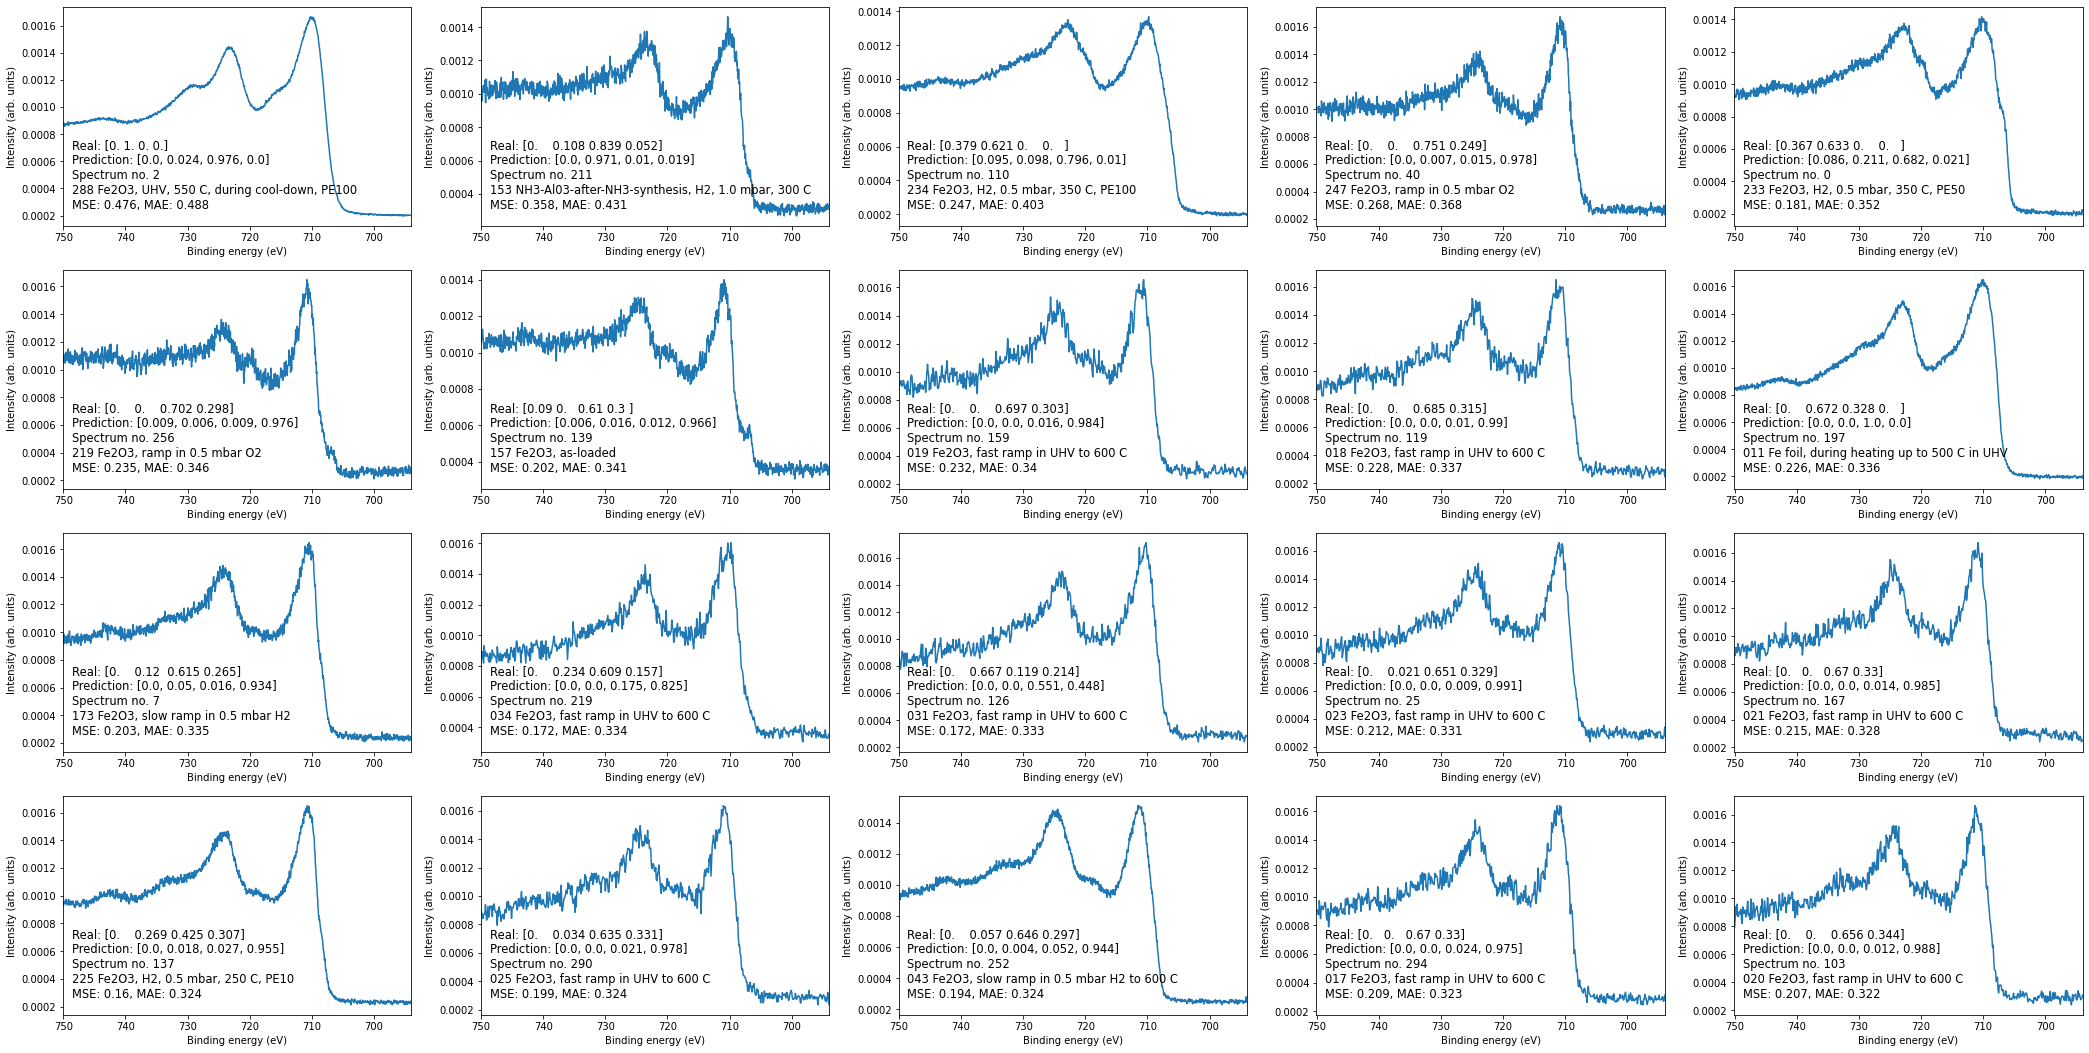

In [43]:
worst_indices = [j[1] for j in sorted([(x,i) for (i,x) in enumerate(mae_losses)],
                          reverse=True)] 
show_worst_of_one_kind(worst_indices, spectra = [0,20])

### Show worst predictions for different loss thresholds (all iron spectra)

27 of 297 test samples (9.1%) have a mean absolute error of of at least 0.3.


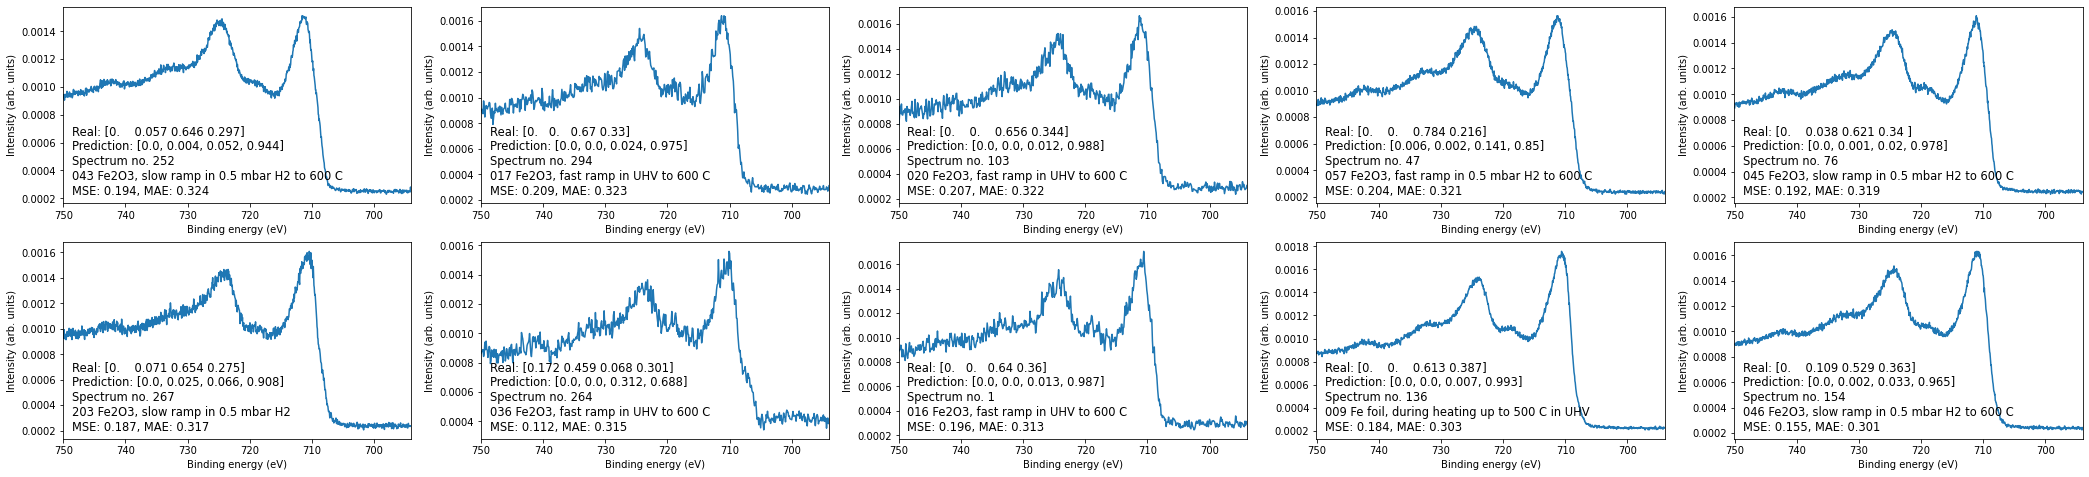

In [44]:
threshold = 0.3
worst_indices_01 = [j[1] for j in sorted([(x,i) for (i,x) in \
                                          enumerate(mae_losses) if x >= threshold],
                             reverse=True)]  
                                             
show_worst_of_one_kind(worst_indices_01,
                       spectra = [len(worst_indices_01)-10,
                                  len(worst_indices_01)])

print('{0} of {1} test samples ({2}%) have a mean absolute error of of at least {3}.'.format(
    str(len(worst_indices_01)),
    str(len(worst_indices)),
    str(100*(np.around(len(worst_indices_01)/len(worst_indices), decimals = 3))),
    str(threshold)))

75 of 297 test samples (25.3%) have a mean absolute error of of at least 0.2.


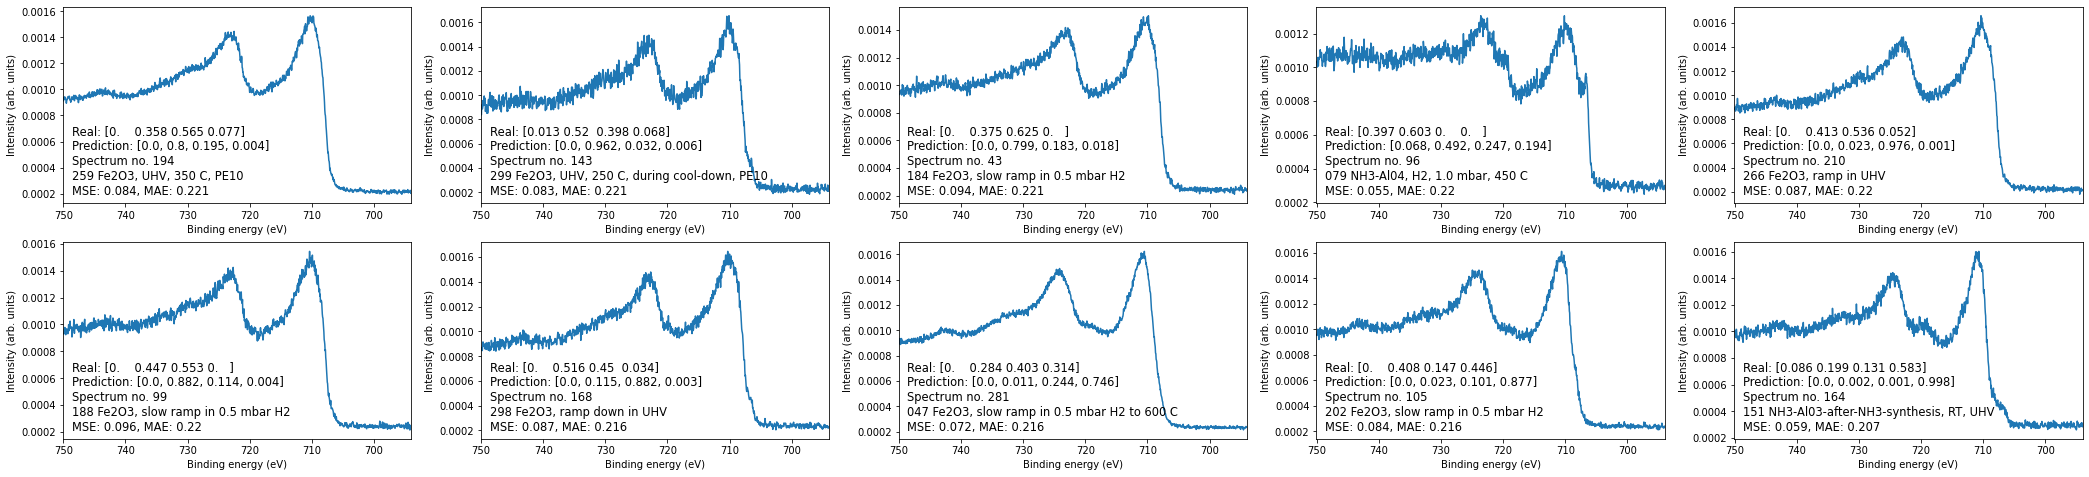

In [45]:
threshold = 0.2
worst_indices_02 = [j[1] for j in sorted([(x,i) for (i,x) in \
                                          enumerate(mae_losses) if x >= threshold],
                             reverse=True)]  
                                             
show_worst_of_one_kind(worst_indices_02,
                       spectra = [len(worst_indices_02)-10,
                                  len(worst_indices_02)])

print('{0} of {1} test samples ({2}%) have a mean absolute error of of at least {3}.'.format(
    str(len(worst_indices_02)),
    str(len(worst_indices)),
    str(100*(np.around(len(worst_indices_02)/len(worst_indices), decimals = 3))),
    str(threshold)))

125 of 297 test samples (42.1%) have a mean absolute error of of at least 0.1.


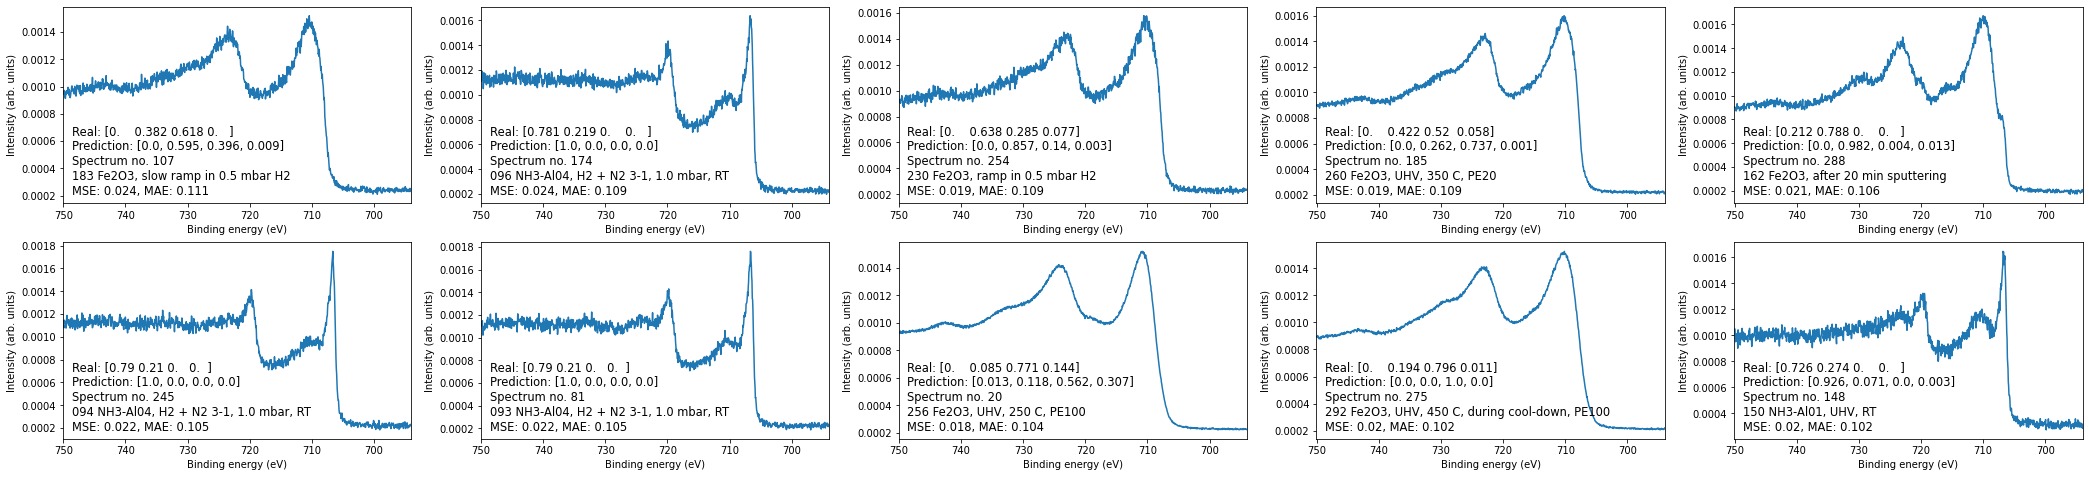

In [46]:
threshold = 0.1
worst_indices_03 = [j[1] for j in sorted([(x,i) for (i,x) in \
                                          enumerate(mae_losses) if x >= threshold],
                             reverse=True)]                 

if (len(worst_indices_03)) > 10:
    show_worst_of_one_kind(worst_indices_03,
                           spectra = [len(worst_indices_03)-10,
                                      len(worst_indices_03)])
else:
    show_worst_of_one_kind(worst_indices_03,
                           spectra = [0,
                                      len(worst_indices_03)])

print('{0} of {1} test samples ({2}%) have a mean absolute error of of at least {3}.'.format(
    str(len(worst_indices_03)),
    str(len(worst_indices)),
    str(100*(np.around(len(worst_indices_03)/len(worst_indices), decimals = 3))),
    str(threshold)))

167 of 297 test samples (56.2%) have a mean absolute error of of at least 0.05.


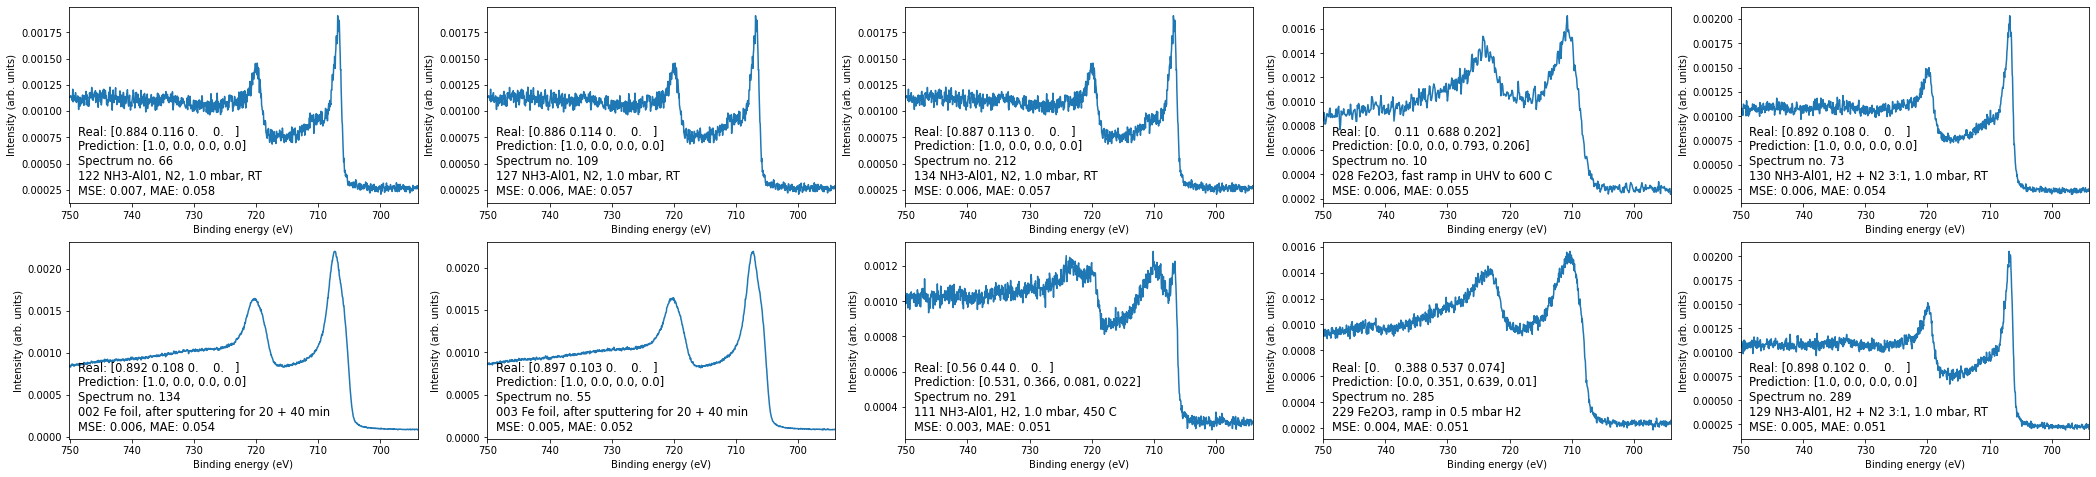

In [47]:
threshold = 0.05
worst_indices_04 = [j[1] for j in sorted([(x,i) for (i,x) in \
                                          enumerate(mae_losses) if x >= threshold],
                             reverse=True)]                 

if (len(worst_indices_04)) > 10:
    show_worst_of_one_kind(worst_indices_04,
                           spectra = [len(worst_indices_04)-10,
                                      len(worst_indices_04)])
else:
    show_worst_of_one_kind(worst_indices_04,
                           spectra = [0,
                                      len(worst_indices_04)])

print('{0} of {1} test samples ({2}%) have a mean absolute error of of at least {3}.'.format(
    str(len(worst_indices_04)),
    str(len(worst_indices)),
    str(100*(np.around(len(worst_indices_04)/len(worst_indices), decimals = 3))),
    str(threshold)))

200 of 297 test samples (67.30000000000001%) have a mean absolute error of of at least 0.025.


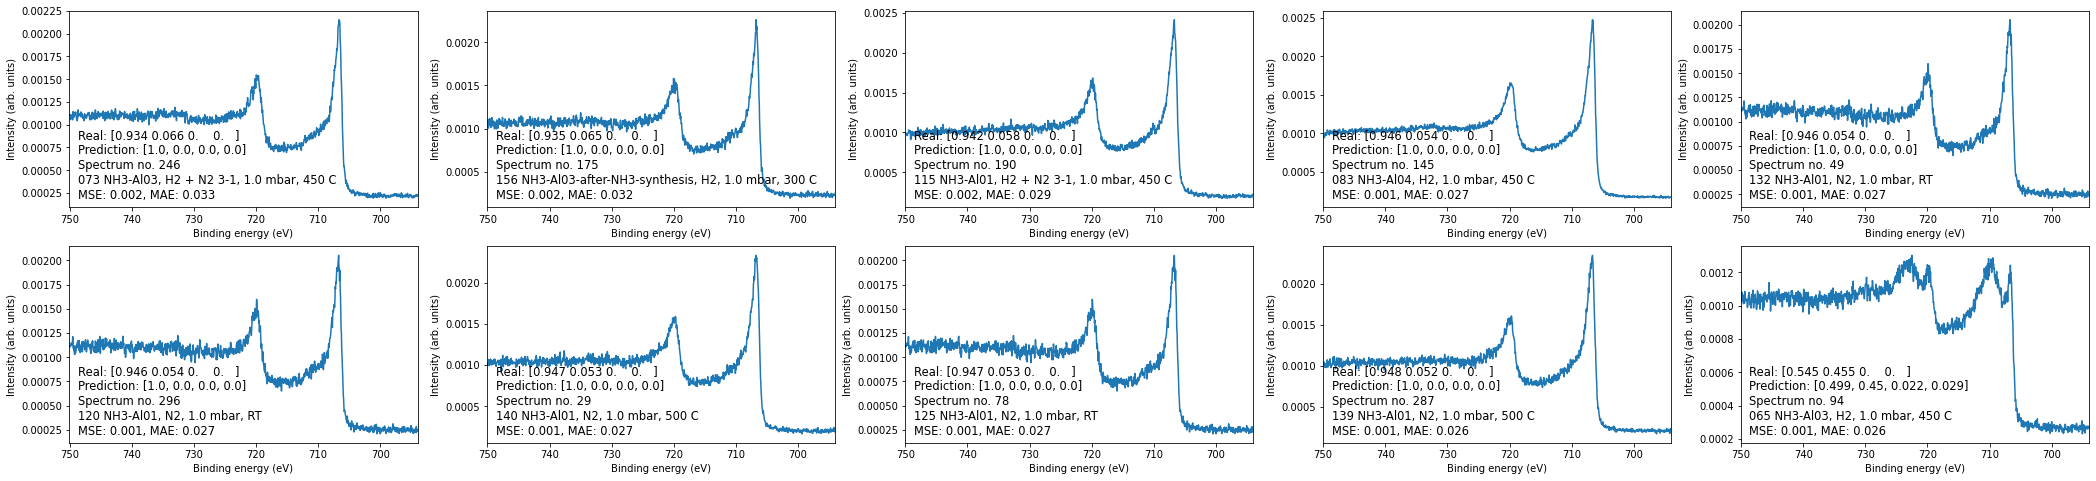

In [48]:
threshold = 0.025
worst_indices_05 = [j[1] for j in sorted([(x,i) for (i,x) in \
                                          enumerate(mae_losses) if x >= threshold],
                             reverse=True)]                 

if (len(worst_indices_05)) > 10:
    show_worst_of_one_kind(worst_indices_05,
                           spectra = [len(worst_indices_05)-10,
                                      len(worst_indices_05)])
else:
    show_worst_of_one_kind(worst_indices_05,
                           spectra = [0,
                                      len(worst_indices_05)])

print('{0} of {1} test samples ({2}%) have a mean absolute error of of at least {3}.'.format(
    str(len(worst_indices_05)),
    str(len(worst_indices)),
    str(100*(np.around(len(worst_indices_05)/len(worst_indices), decimals = 3))),
    str(threshold)))

212 of 297 test samples (71.39999999999999%) have a mean absolute error of of at least 0.01.


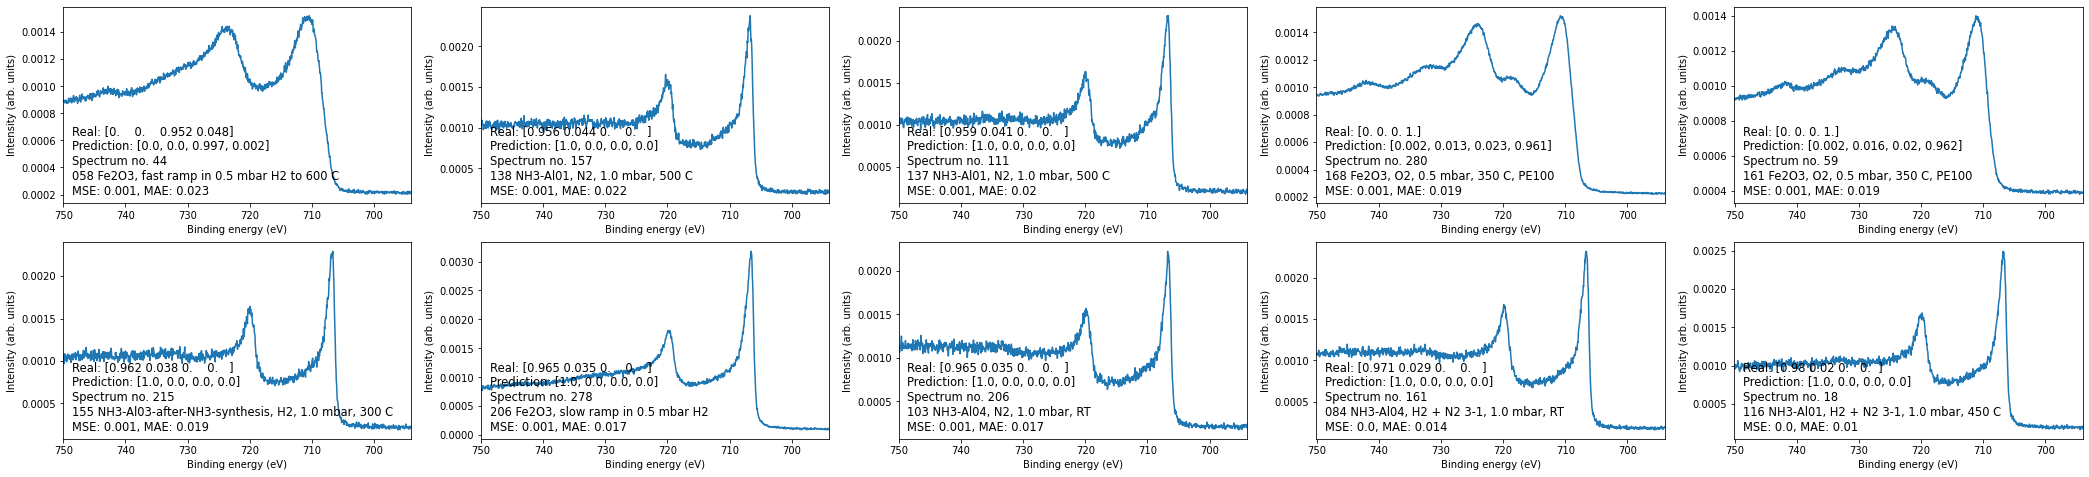

In [49]:
threshold = 0.01
worst_indices_06 = [j[1] for j in sorted([(x,i) for (i,x) in \
                                          enumerate(mae_losses) if x >= threshold],
                             reverse=True)]                 

if (len(worst_indices_06)) > 10:
    show_worst_of_one_kind(worst_indices_06,
                           spectra = [len(worst_indices_06)-10,
                                      len(worst_indices_06)])
else:
    show_worst_of_one_kind(worst_indices_06,
                           spectra = [0,
                                      len(worst_indices_06)])

print('{0} of {1} test samples ({2}%) have a mean absolute error of of at least {3}.'.format(
    str(len(worst_indices_06)),
    str(len(worst_indices)),
    str(100*(np.around(len(worst_indices_06)/len(worst_indices), decimals = 3))),
    str(threshold)))

218 of 297 test samples (73.4%) have a mean absolute error of of at least 0.005.


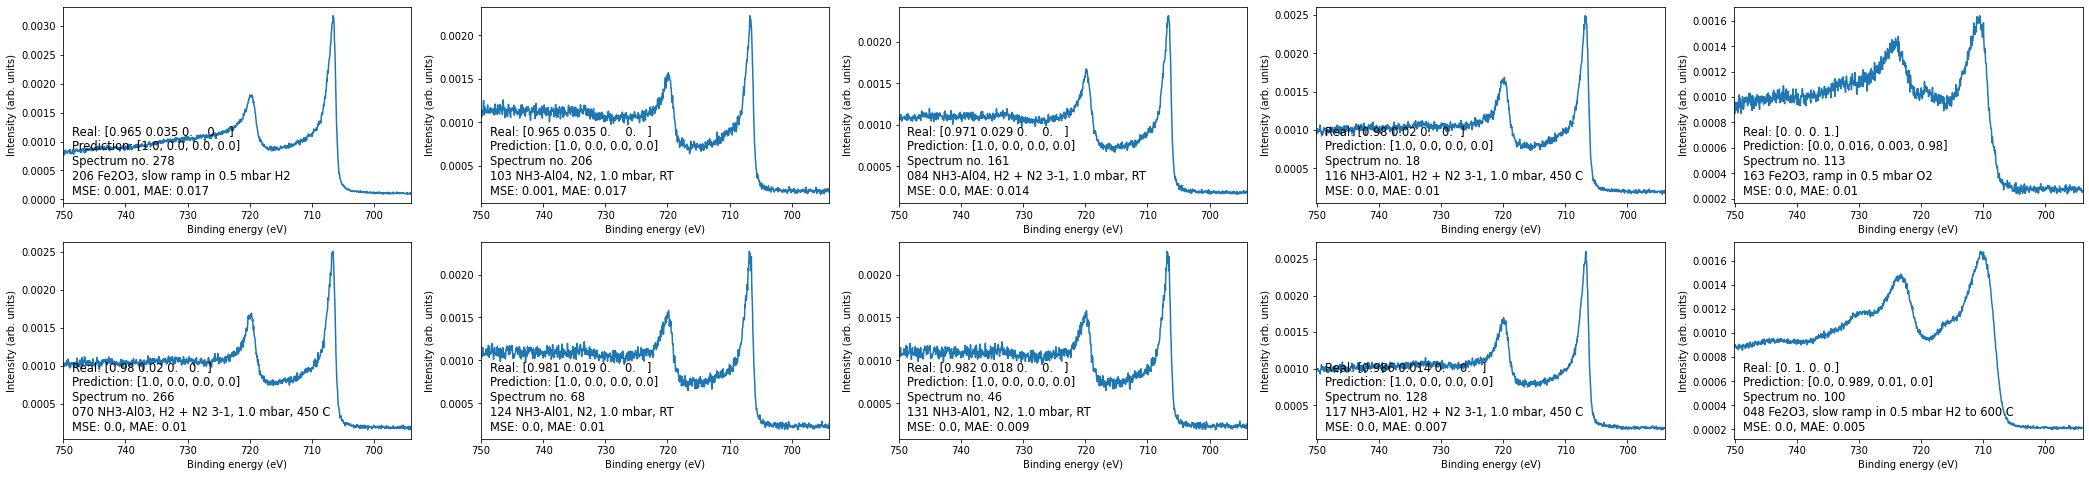

In [50]:
threshold = 0.005
worst_indices_07 = [j[1] for j in sorted([(x,i) for (i,x) in \
                                          enumerate(mae_losses) if x >= threshold],
                             reverse=True)]                 

if (len(worst_indices_07)) > 10:
    show_worst_of_one_kind(worst_indices_07,
                           spectra = [len(worst_indices_07)-10,
                                      len(worst_indices_07)])
else:
    show_worst_of_one_kind(worst_indices_07,
                           spectra = [0,
                                      len(worst_indices_07)])

print('{0} of {1} test samples ({2}%) have a mean absolute error of of at least {3}.'.format(
    str(len(worst_indices_07)),
    str(len(worst_indices)),
    str(100*(np.around(len(worst_indices_07)/len(worst_indices), decimals = 3))),
    str(threshold)))

221 of 297 test samples (74.4%) have a mean absolute error of of at least 0.001.


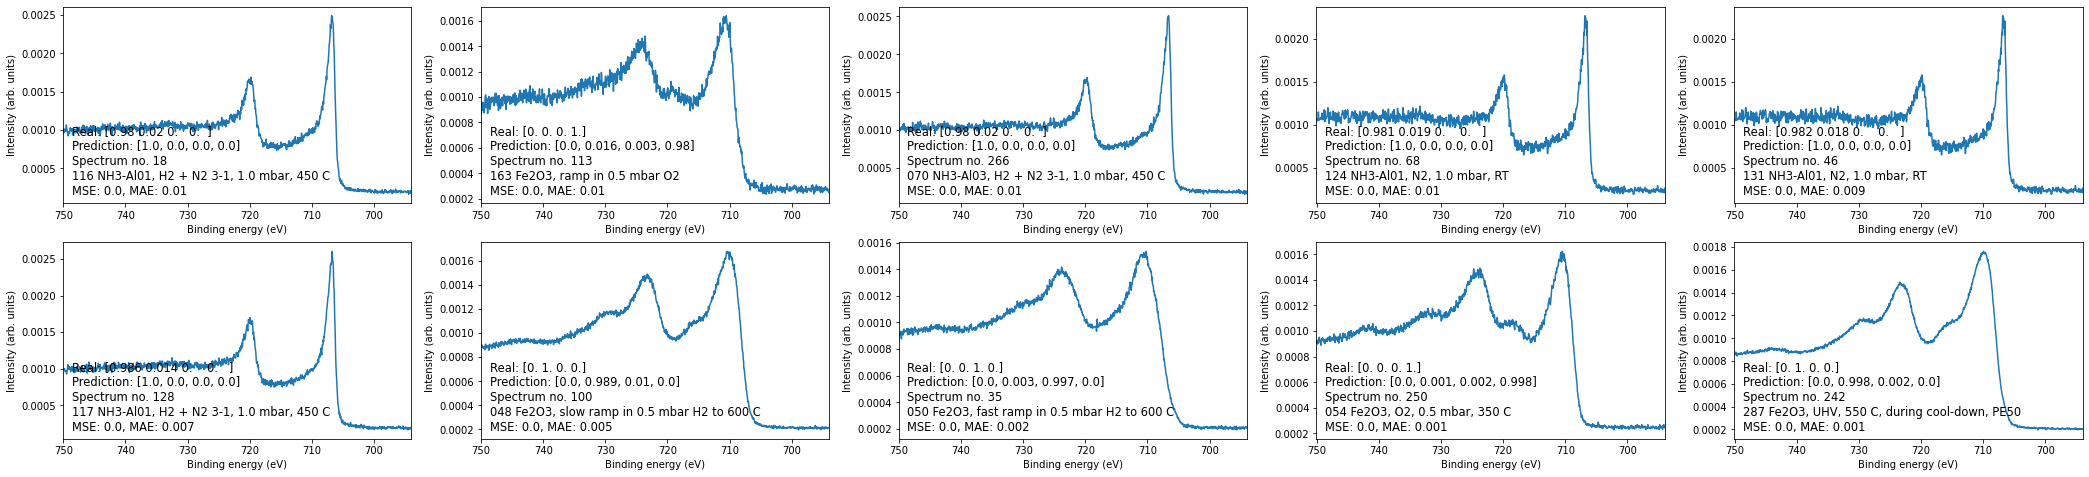

In [51]:
threshold = 0.001
worst_indices_08 = [j[1] for j in sorted([(x,i) for (i,x) in \
                                          enumerate(mae_losses) if x >= threshold],
                             reverse=True)]                 

if (len(worst_indices_08)) > 10:
    show_worst_of_one_kind(worst_indices_08,
                           spectra = [len(worst_indices_08)-10,
                                      len(worst_indices_08)])
else:
    show_worst_of_one_kind(worst_indices_08,
                           spectra = [0,
                                      len(worst_indices_08)])

print('{0} of {1} test samples ({2}%) have a mean absolute error of of at least {3}.'.format(
    str(len(worst_indices_08)),
    str(len(worst_indices)),
    str(100*(np.around(len(worst_indices_08)/len(worst_indices), decimals = 3))),
    str(threshold)))

221 of 297 test samples (74.4%) have a mean absolute error of of at least 0.0005.


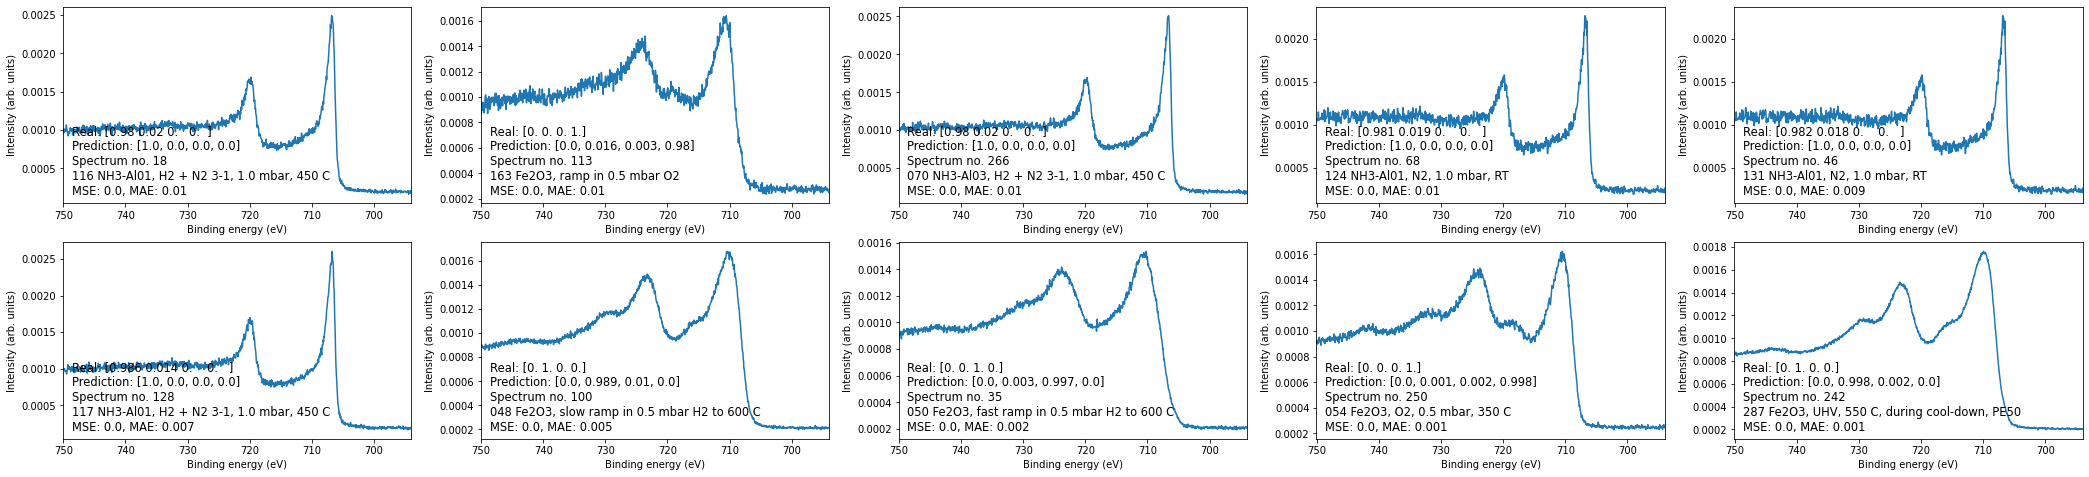

In [52]:
threshold = 0.0005
worst_indices_09 = [j[1] for j in sorted([(x,i) for (i,x) in \
                                          enumerate(mae_losses) if x >= threshold],
                             reverse=True)]                 

if (len(worst_indices_09)) > 10:
    show_worst_of_one_kind(worst_indices_09,
                           spectra = [len(worst_indices_09)-10,
                                      len(worst_indices_09)])
else:
    show_worst_of_one_kind(worst_indices_09,
                           spectra = [0,
                                      len(worst_indices_09)])

print('{0} of {1} test samples ({2}%) have a mean absolute error of of at least {3}.'.format(
    str(len(worst_indices_09)),
    str(len(worst_indices)),
    str(100*(np.around(len(worst_indices_09)/len(worst_indices), decimals = 3))),
    str(threshold)))

224 of 297 test samples (75.4%) have a mean absolute error of of at least 0.00025.


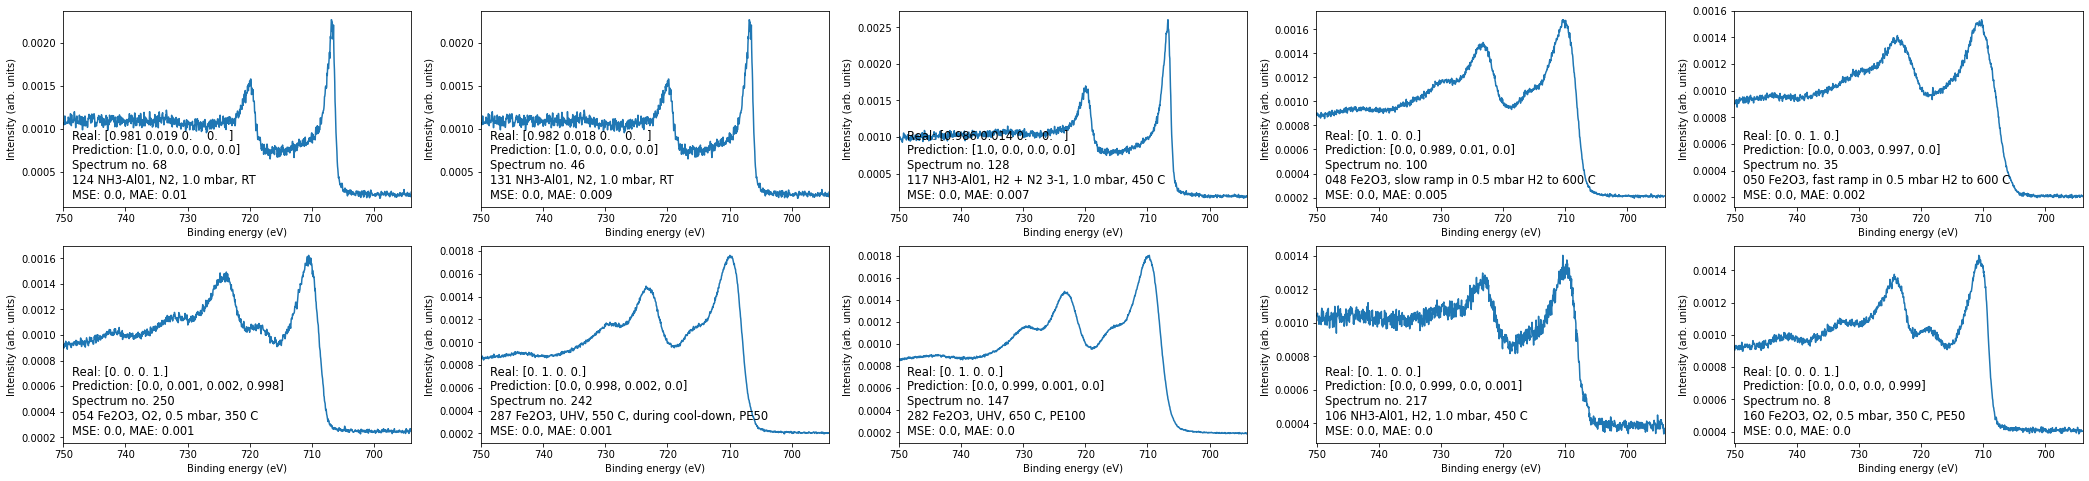

In [53]:
threshold = 0.00025
worst_indices_10 = [j[1] for j in sorted([(x,i) for (i,x) in \
                                          enumerate(mae_losses) if x >= threshold],
                             reverse=True)]                 

if (len(worst_indices_10)) > 10:
    show_worst_of_one_kind(worst_indices_10,
                           spectra = [len(worst_indices_10)-10,
                                      len(worst_indices_10)])
else:
    show_worst_of_one_kind(worst_indices_10,
                           spectra = [0,
                                      len(worst_indices_10)])

print('{0} of {1} test samples ({2}%) have a mean absolute error of of at least {3}.'.format(
    str(len(worst_indices_10)),
    str(len(worst_indices)),
    str(100*(np.around(len(worst_indices_10)/len(worst_indices), decimals = 3))),
    str(threshold)))

227 of 297 test samples (76.4%) have a mean absolute error of of at least 0.0001.


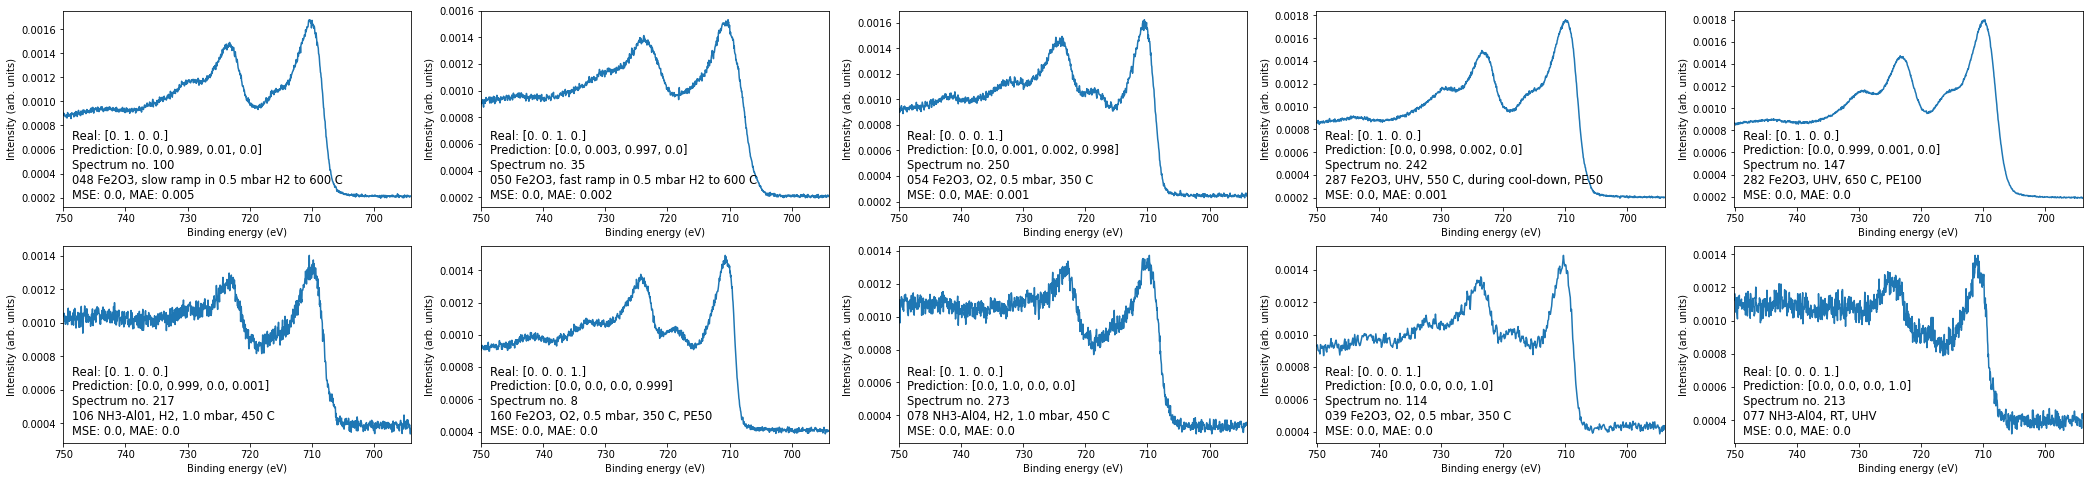

In [54]:
threshold = 0.0001
worst_indices_11 = [j[1] for j in sorted([(x,i) for (i,x) in \
                                          enumerate(mae_losses) if x >= threshold],
                             reverse=True)]                 

if (len(worst_indices_11)) > 10:
    show_worst_of_one_kind(worst_indices_11,
                           spectra = [len(worst_indices_11)-10,
                                      len(worst_indices_11)])
else:
    show_worst_of_one_kind(worst_indices_11,
                           spectra = [0,
                                      len(worst_indices_11)])

print('{0} of {1} test samples ({2}%) have a mean absolute error of of at least {3}.'.format(
    str(len(worst_indices_11)),
    str(len(worst_indices)),
    str(100*(np.around(len(worst_indices_11)/len(worst_indices), decimals = 3))),
    str(threshold)))

232 of 297 test samples (78.10000000000001%) have a mean absolute error of of at least 1e-05.


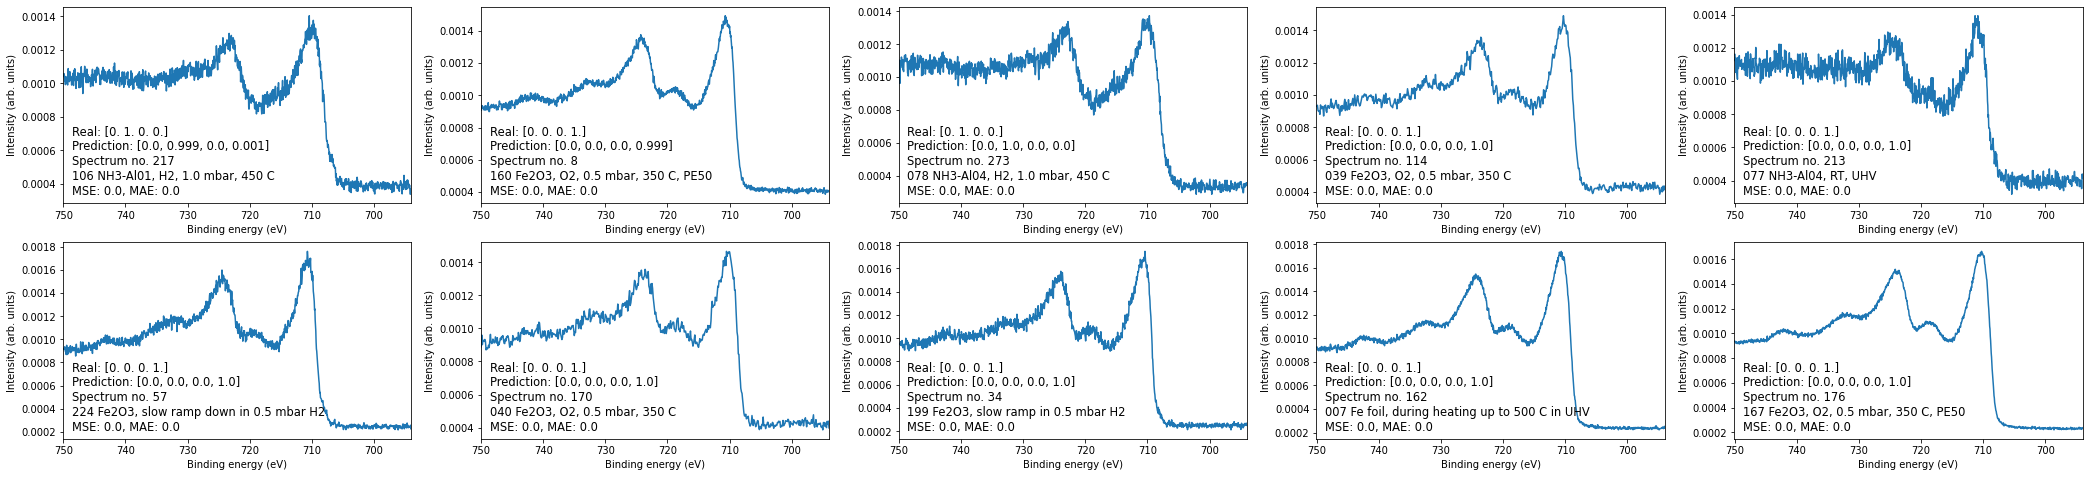

In [59]:
threshold = 0.00001
worst_indices_12 = [j[1] for j in sorted([(x,i) for (i,x) in \
                                          enumerate(mae_losses) if x >= threshold],
                             reverse=True)]                 

if (len(worst_indices_12)) > 10:
    show_worst_of_one_kind(worst_indices_12,
                           spectra = [len(worst_indices_12)-10,
                                      len(worst_indices_12)])
else:
    show_worst_of_one_kind(worst_indices_12,
                           spectra = [0,
                                      len(worst_indices_12)])

print('{0} of {1} test samples ({2}%) have a mean absolute error of of at least {3}.'.format(
    str(len(worst_indices_12)),
    str(len(worst_indices)),
    str(100*(np.around(len(worst_indices_12)/len(worst_indices), decimals = 3))),
    str(threshold)))

## Save output of notebook

In [60]:
from IPython.display import Javascript, display
from nbconvert import HTMLExporter

def save_notebook():
    display(Javascript("IPython.notebook.save_notebook()"),
            include=['application/javascript'])

def output_HTML(read_file, output_file):
    import codecs
    import nbformat
    exporter = HTMLExporter()
    # read_file is '.ipynb', output_file is '.html'
    output_notebook = nbformat.read(read_file, as_version=4)
    output, resources = exporter.from_notebook_node(output_notebook)
    codecs.open(output_file, 'w', encoding='utf-8').write(output)

import time
import os

time.sleep(20)
save_notebook()
print('Notebook saved!')
time.sleep(30)
current_file = '/content/drive/My Drive/app/xpsdeeplearning/predict_unknown_multiple.ipynb'
output_file = os.path.join(clf.log_dir,'predict_unknown_multiple_out.html')
output_HTML(current_file, output_file)
print('HTML file saved!')

Notebook saved!


/usr/local/lib/python3.6/dist-packages/nbconvert/filters/datatypefilter.py:41: UserWarning: Your element with mimetype(s) dict_keys(['application/vnd.colab-display-data+json']) is not able to be represented.
  mimetypes=output.keys())


HTML file saved!
